### Дальнейшие эксперементы проводились на реализованной с нуля архитектуры ResNet с изменением структуры, оптимизаторов и расширением аугментаций, а так же с использованием уже предобученной модели (с дообучением на моих данных)

In [87]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models 
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

### Базовая структура с одиним линейным полносвязным слоем
#### Модель ResNet
#### Функция потерь - CrossEntropyLoss
#### Оптимизатор - AdamW

#### Аугментации - RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize

In [64]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = 10  # Количество пород собак
batch_size = 32
epochs = 30

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        return F.relu(out)

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=75):
        super().__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def ResNet18(num_classes=75):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

class DogDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = []
        self.labels = []  # Добавляем атрибут для хранения меток
        self.transform = transform
        
        for cls in self.classes:
            cls_dir = os.path.join(root_dir, cls)
            for img_name in os.listdir(cls_dir):
                if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    self.images.append((os.path.join(cls_dir, img_name), self.class_to_idx[cls]))
                    self.labels.append(self.class_to_idx[cls])  # Сохраняем метку
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [65]:
# Аугментации
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

full_dataset = DogDataset(
    root_dir="C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs10",
    transform=train_transform  )

train_idx, temp_idx = train_test_split(
    range(len(full_dataset)),
    test_size=0.2,
    stratify=full_dataset.labels,  # Важно для баланса классов
    random_state=42)


val_idx, test_idx = train_test_split(
    temp_idx,
    test_size=0.5,
    stratify=[full_dataset.labels[i] for i in temp_idx],
    random_state=42)

train_dataset = torch.utils.data.Subset(full_dataset, train_idx)
val_dataset = torch.utils.data.Subset(full_dataset, val_idx)
test_dataset = torch.utils.data.Subset(full_dataset, test_idx)

val_dataset.dataset.transform = val_transform
test_dataset.dataset.transform = val_transform

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [66]:
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return accuracy, precision, recall, f1

def evaluate(model, dataloader, class_names=None, plot_cm=True):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Вычисляем метрики
    accuracy, precision, recall, f1 = calculate_metrics(all_labels, all_preds)
    
    # Вычисляем confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    if plot_cm:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else np.unique(all_labels),
                    yticklabels=class_names if class_names else np.unique(all_labels))
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45 if class_names else 0)
        plt.yticks(rotation=0)
        plt.tight_layout()
        plt.show()
    
    return accuracy, precision, recall, f1, cm

Epoch 1/30: 100%|██████████| 36/36 [00:55<00:00,  1.55s/it]


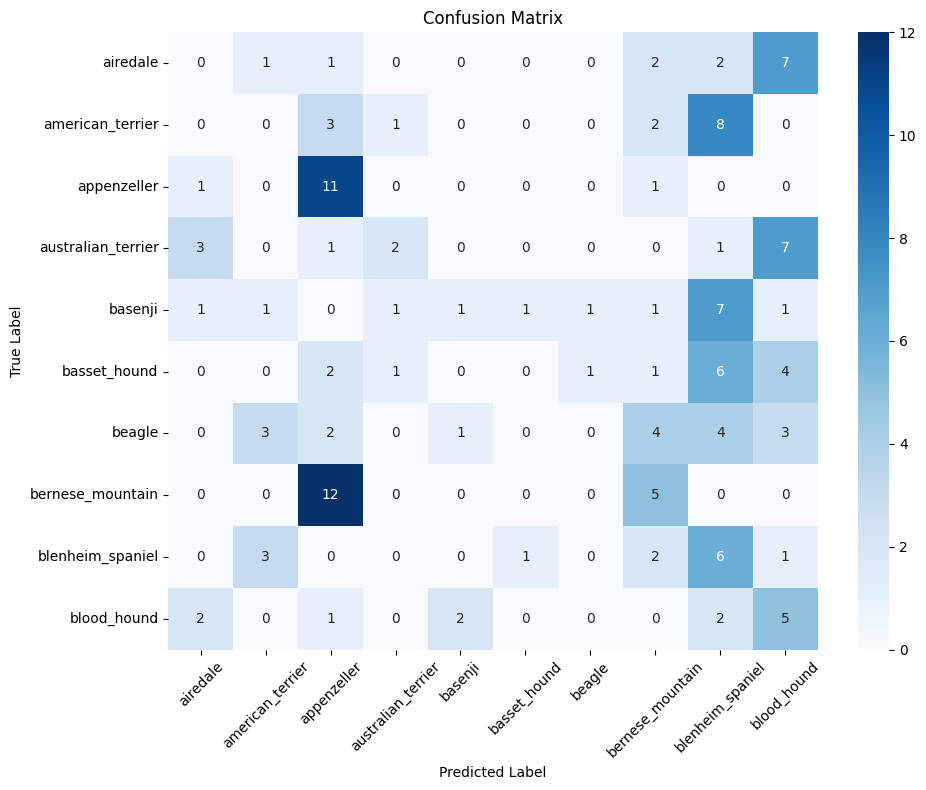


Epoch 1/30
Train Loss: 2.1405
Val Accuracy: 0.2098
Val Precision: 0.1606
Val Recall: 0.2228
Val F1: 0.1575


Epoch 2/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


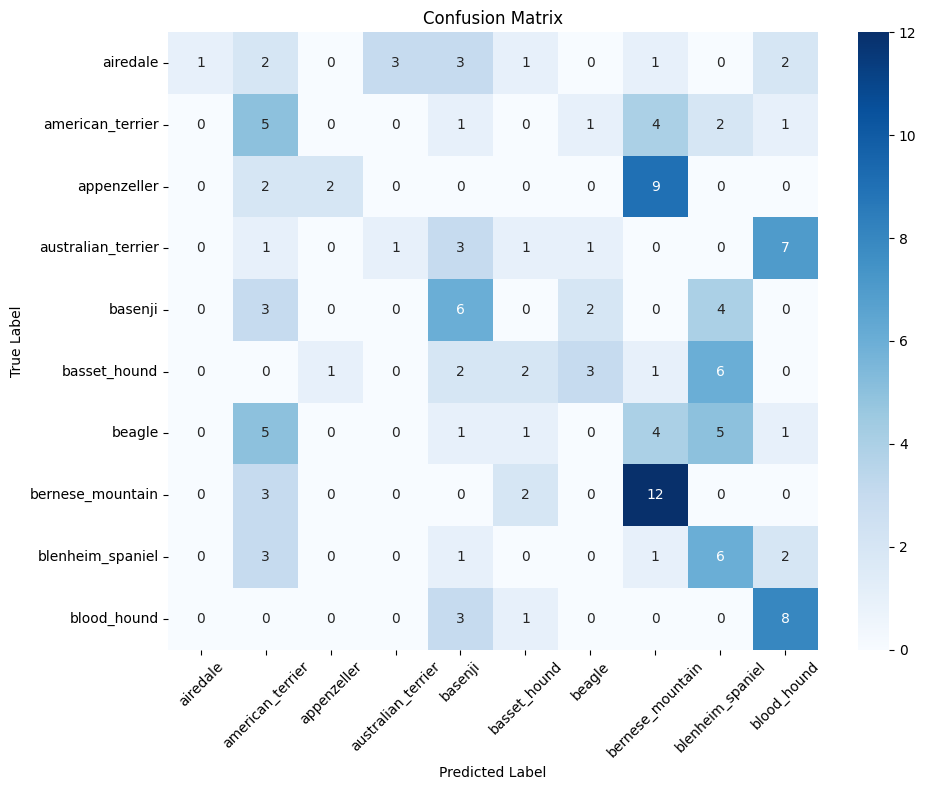


Epoch 2/30
Train Loss: 1.8367
Val Accuracy: 0.3007
Val Precision: 0.3692
Val Recall: 0.3027
Val F1: 0.2592


Epoch 3/30: 100%|██████████| 36/36 [01:00<00:00,  1.68s/it]


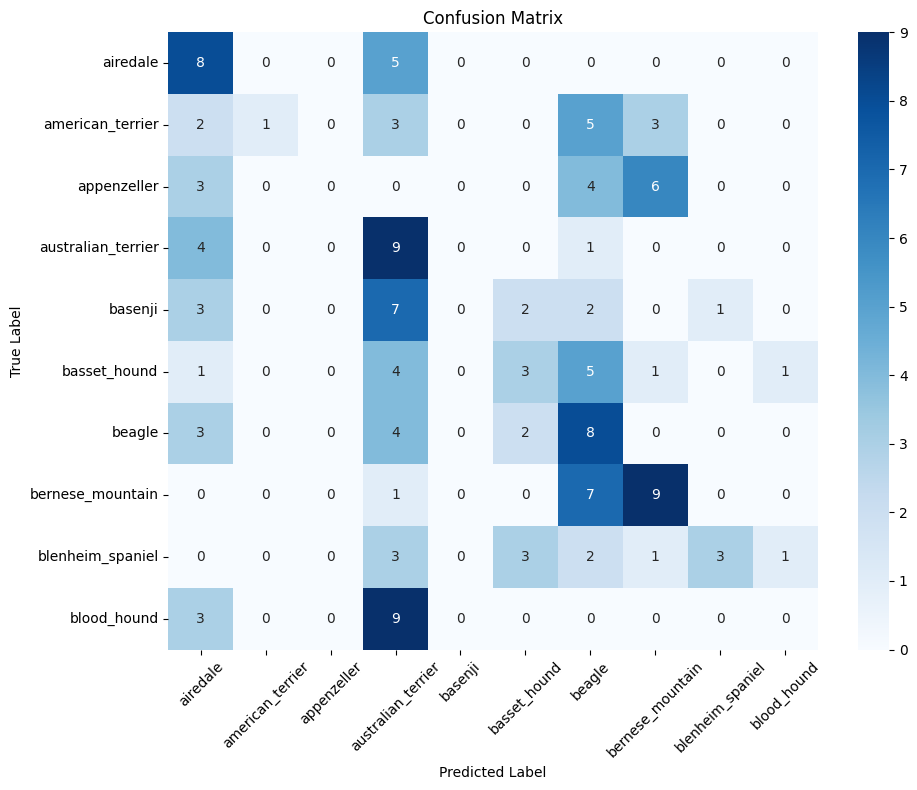


Epoch 3/30
Train Loss: 1.5864
Val Accuracy: 0.2867
Val Precision: 0.3232
Val Recall: 0.2760
Val F1: 0.2232


Epoch 4/30: 100%|██████████| 36/36 [00:58<00:00,  1.61s/it]


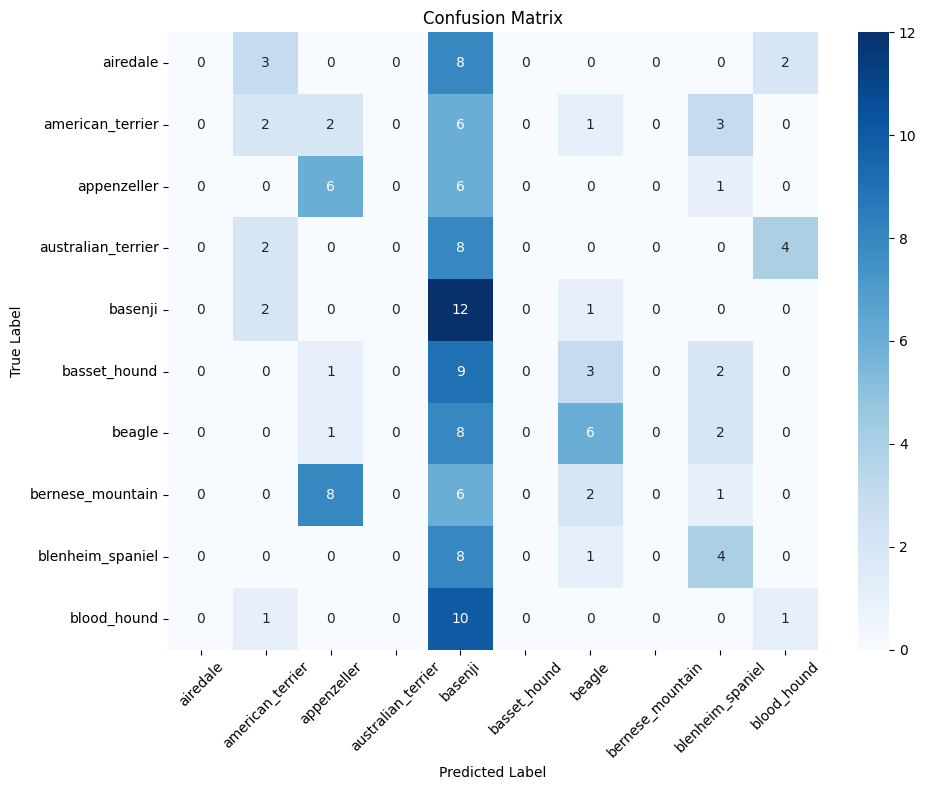


Epoch 4/30
Train Loss: 1.4204
Val Accuracy: 0.2168
Val Precision: 0.1561
Val Recall: 0.2148
Val F1: 0.1604


Epoch 5/30: 100%|██████████| 36/36 [00:57<00:00,  1.61s/it]


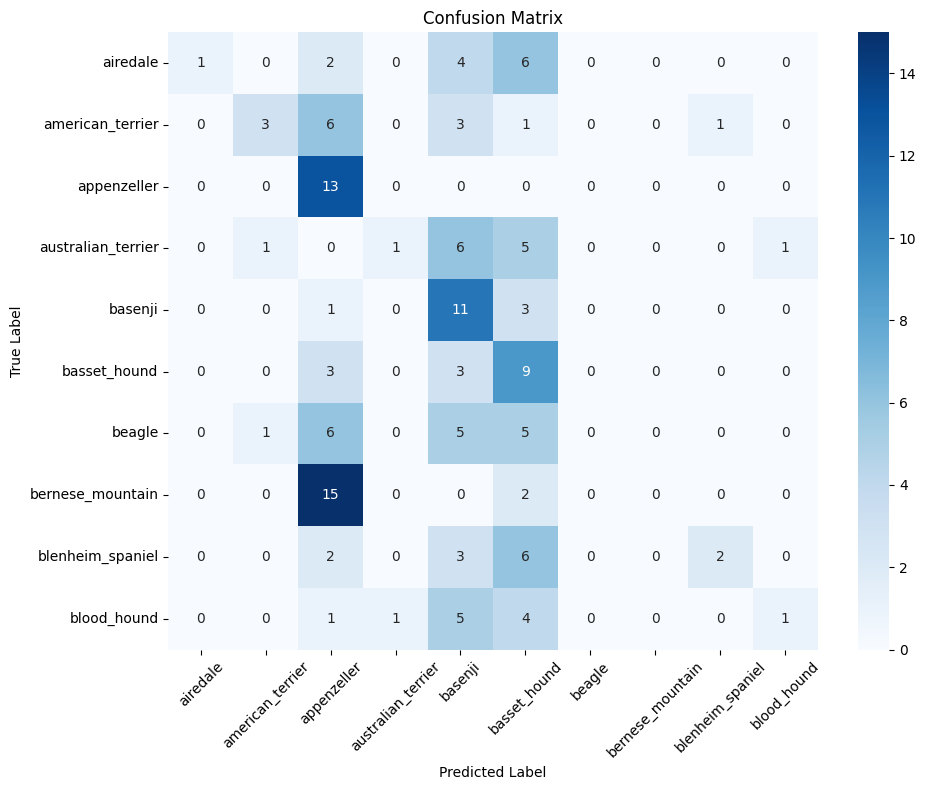


Epoch 5/30
Train Loss: 1.3393
Val Accuracy: 0.2867
Val Precision: 0.4026
Val Recall: 0.2933
Val F1: 0.2117
Epoch 00005: reducing learning rate of group 0 to 1.5000e-04.


Epoch 6/30: 100%|██████████| 36/36 [00:57<00:00,  1.61s/it]


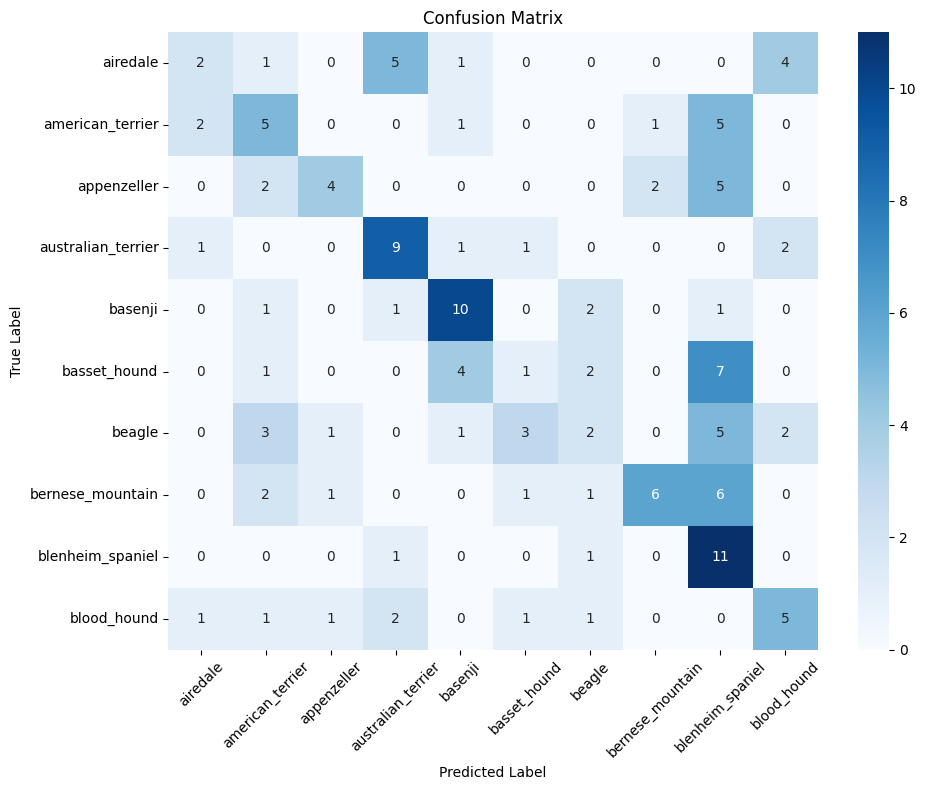


Epoch 6/30
Train Loss: 0.9715
Val Accuracy: 0.3846
Val Precision: 0.3964
Val Recall: 0.3928
Val F1: 0.3634


Epoch 7/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


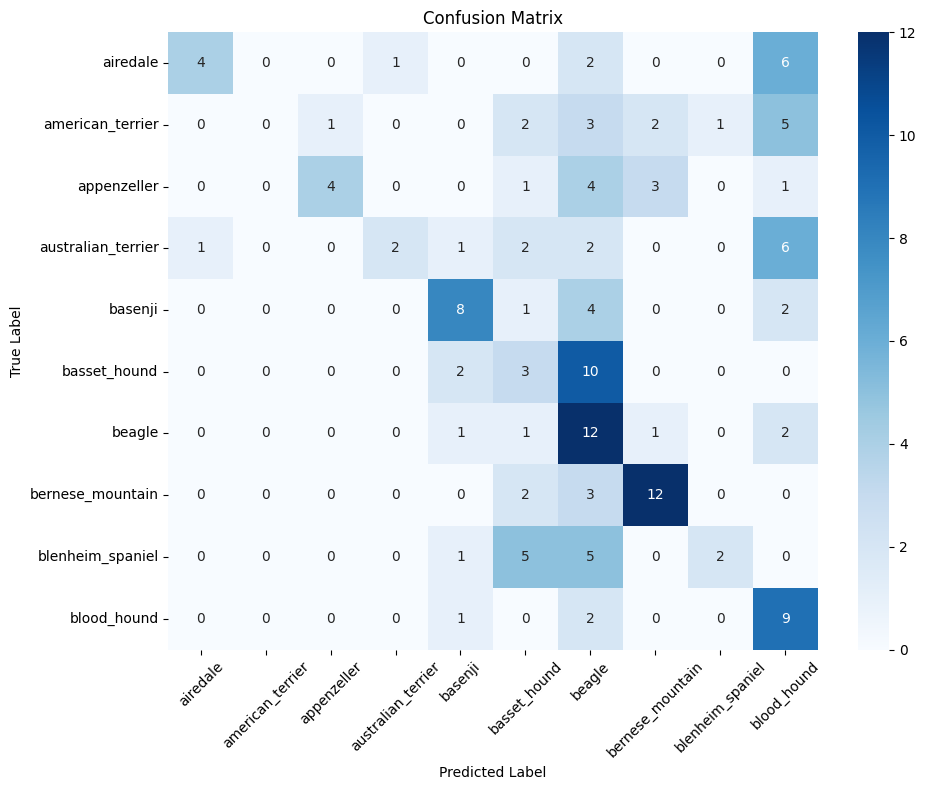


Epoch 7/30
Train Loss: 0.7313
Val Accuracy: 0.3916
Val Precision: 0.4894
Val Recall: 0.3807
Val F1: 0.3593


Epoch 8/30: 100%|██████████| 36/36 [00:57<00:00,  1.60s/it]


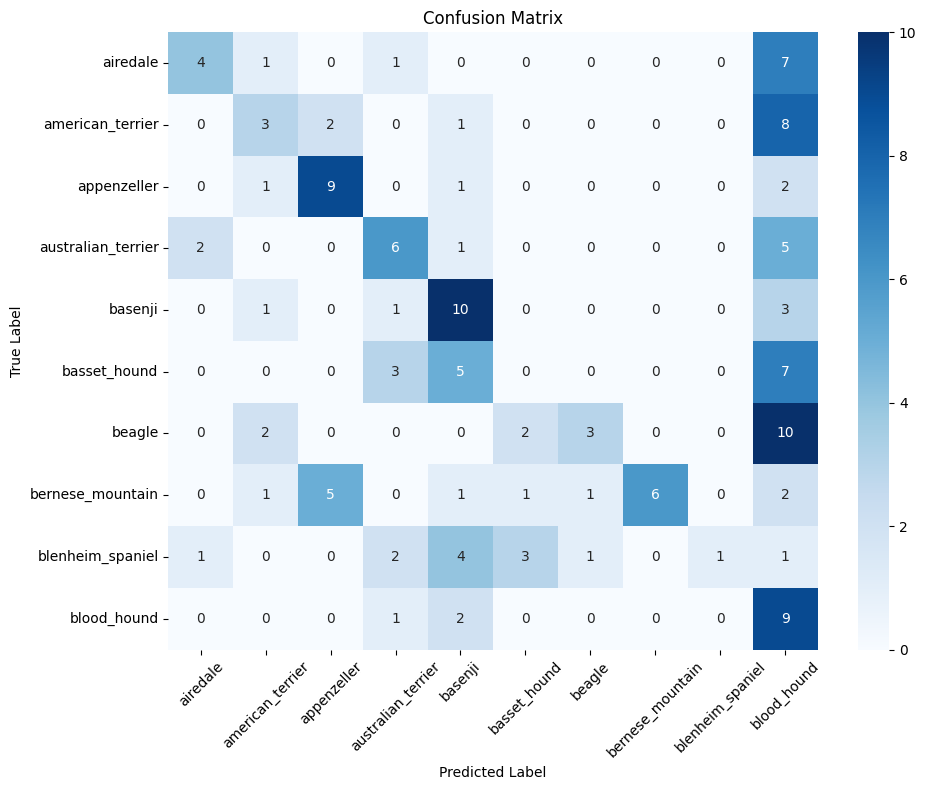


Epoch 8/30
Train Loss: 0.5450
Val Accuracy: 0.3566
Val Precision: 0.5062
Val Recall: 0.3666
Val F1: 0.3420


Epoch 9/30: 100%|██████████| 36/36 [00:57<00:00,  1.61s/it]


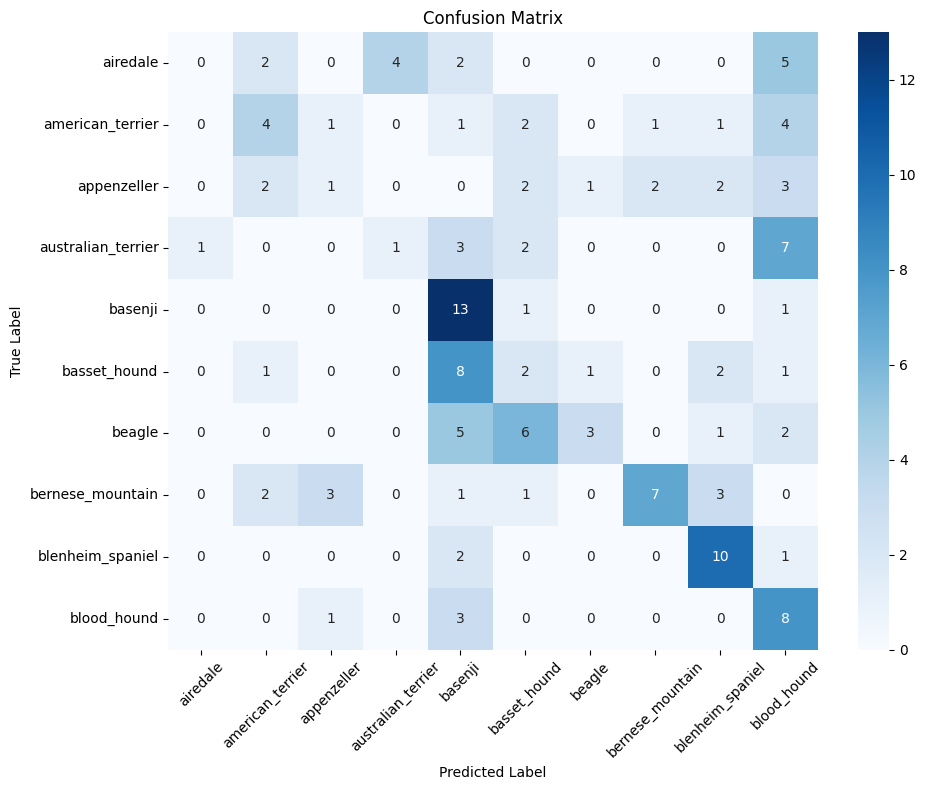


Epoch 9/30
Train Loss: 0.3840
Val Accuracy: 0.3427
Val Precision: 0.3274
Val Recall: 0.3458
Val F1: 0.2930
Epoch 00009: reducing learning rate of group 0 to 7.5000e-05.


Epoch 10/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


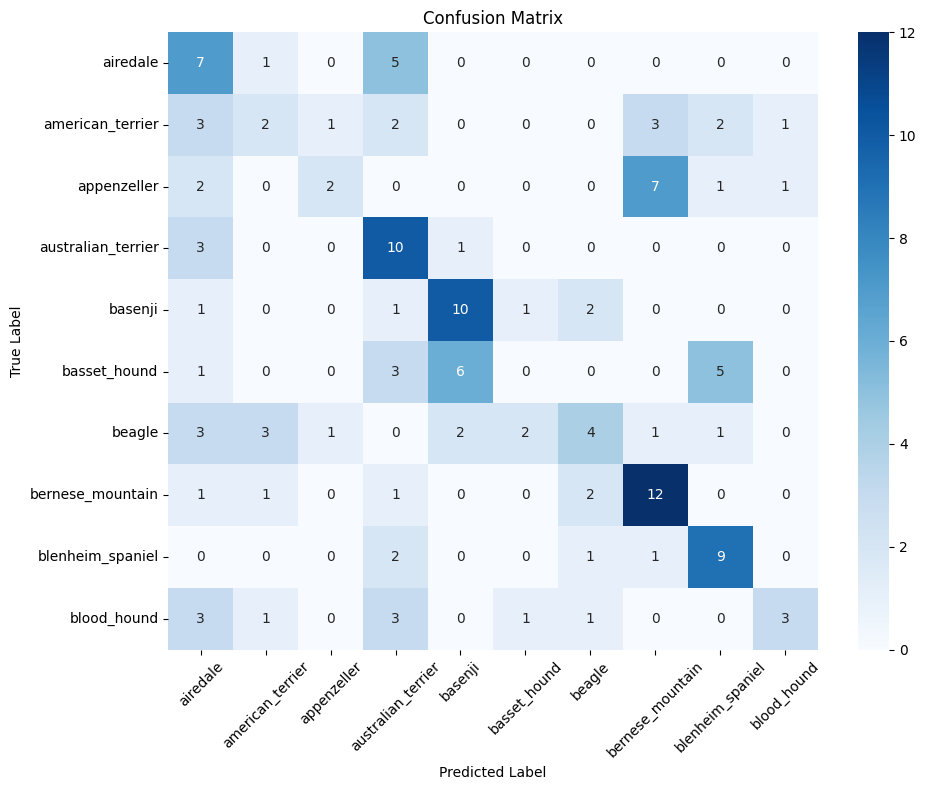


Epoch 10/30
Train Loss: 0.1813
Val Accuracy: 0.4126
Val Precision: 0.3938
Val Recall: 0.4100
Val F1: 0.3687


Epoch 11/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


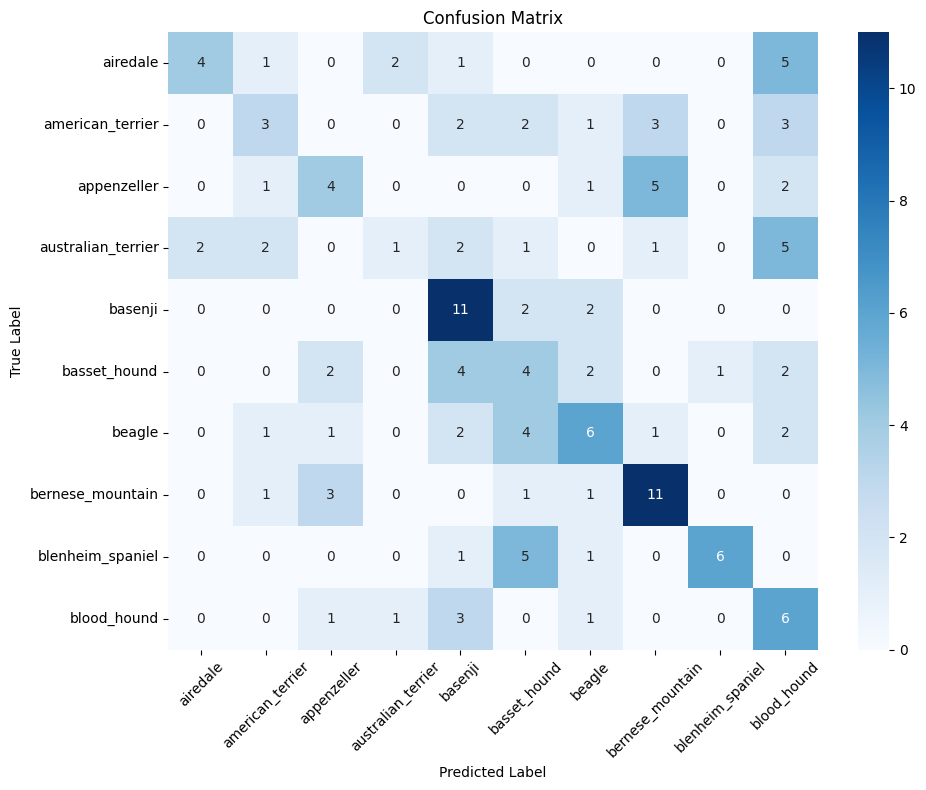


Epoch 11/30
Train Loss: 0.1106
Val Accuracy: 0.3916
Val Precision: 0.4268
Val Recall: 0.3863
Val F1: 0.3777


Epoch 12/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


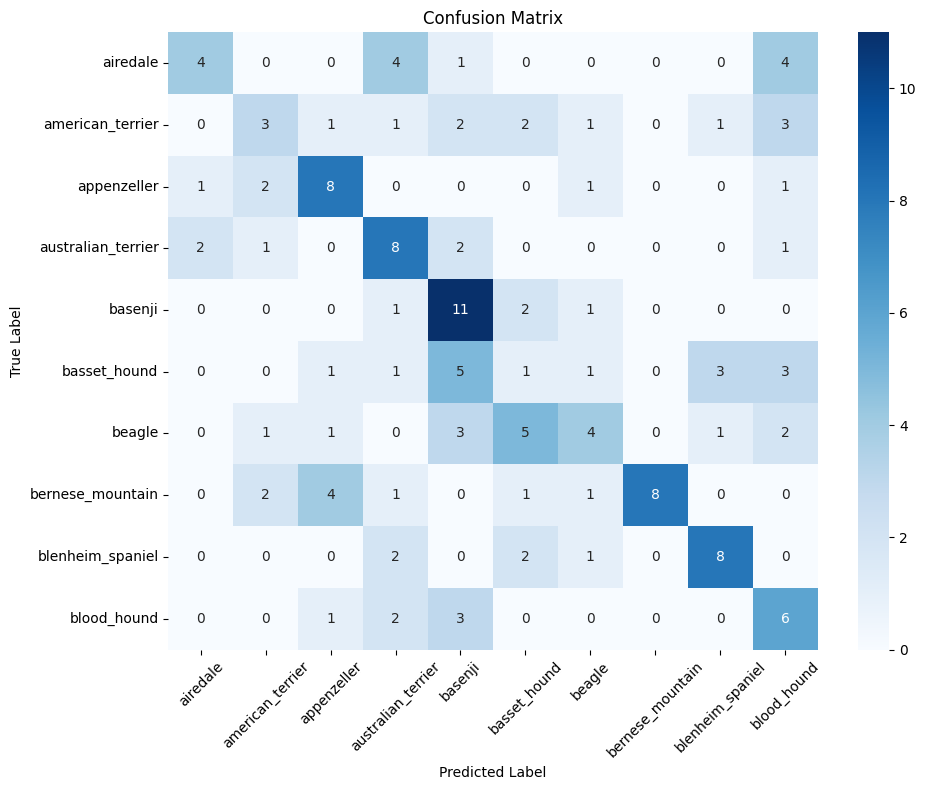


Epoch 12/30
Train Loss: 0.0606
Val Accuracy: 0.4266
Val Precision: 0.4604
Val Recall: 0.4330
Val F1: 0.4205


Epoch 13/30: 100%|██████████| 36/36 [00:59<00:00,  1.64s/it]


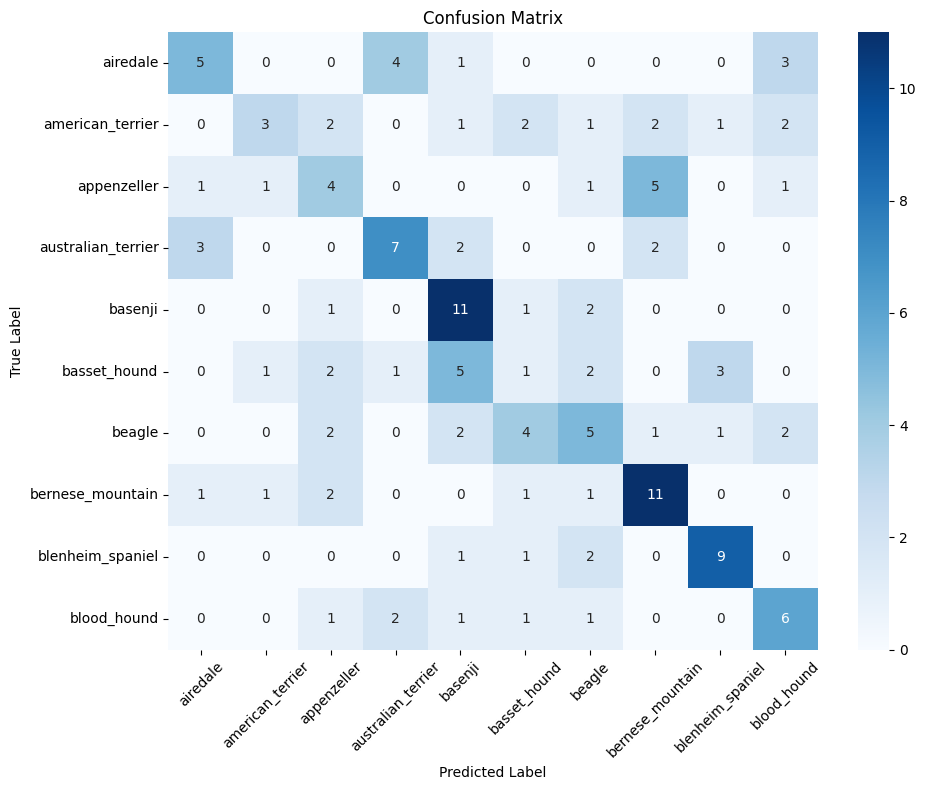


Epoch 13/30
Train Loss: 0.0338
Val Accuracy: 0.4336
Val Precision: 0.4264
Val Recall: 0.4340
Val F1: 0.4192


Epoch 14/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


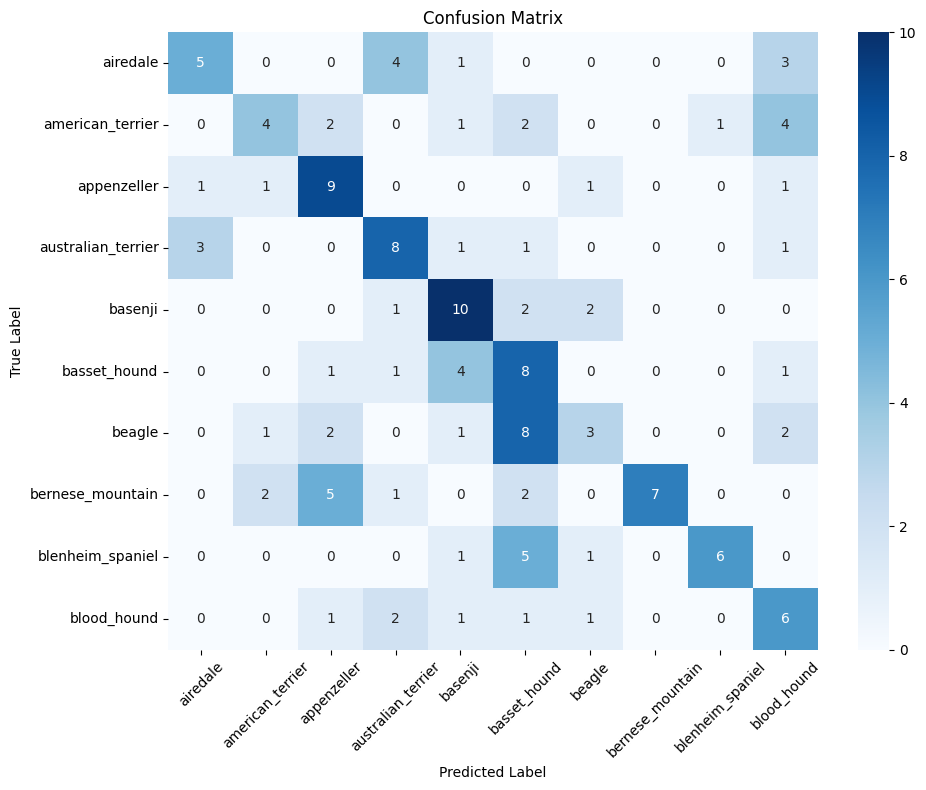


Epoch 14/30
Train Loss: 0.0288
Val Accuracy: 0.4615
Val Precision: 0.5317
Val Recall: 0.4684
Val F1: 0.4638


Epoch 15/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


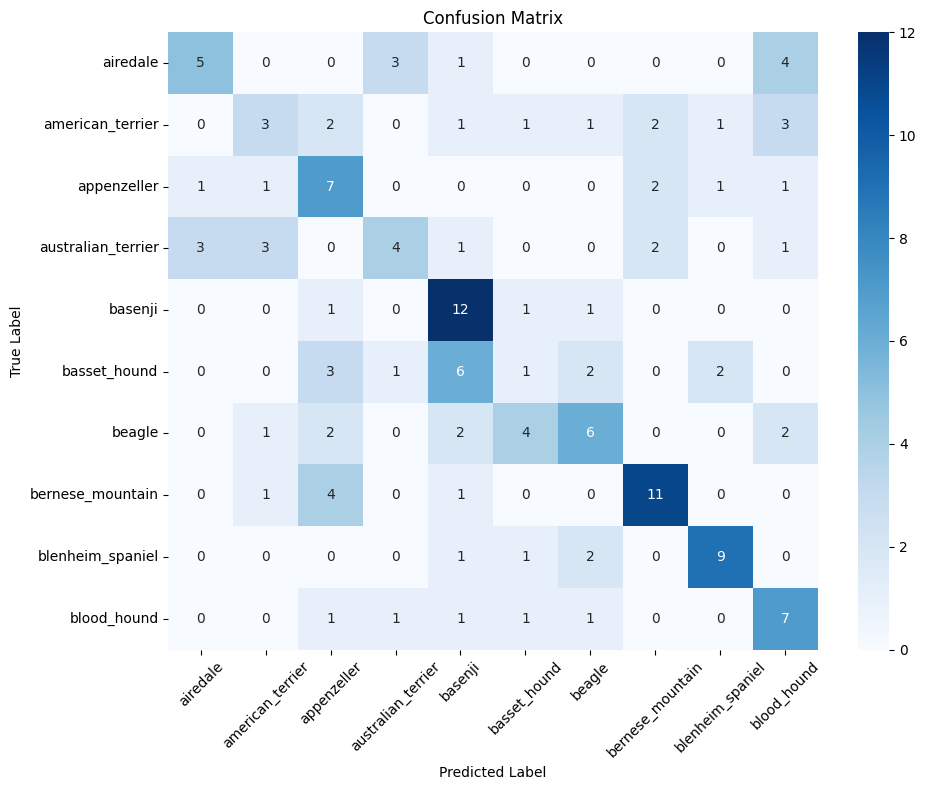


Epoch 15/30
Train Loss: 0.0228
Val Accuracy: 0.4545
Val Precision: 0.4446
Val Recall: 0.4565
Val F1: 0.4362


Epoch 16/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


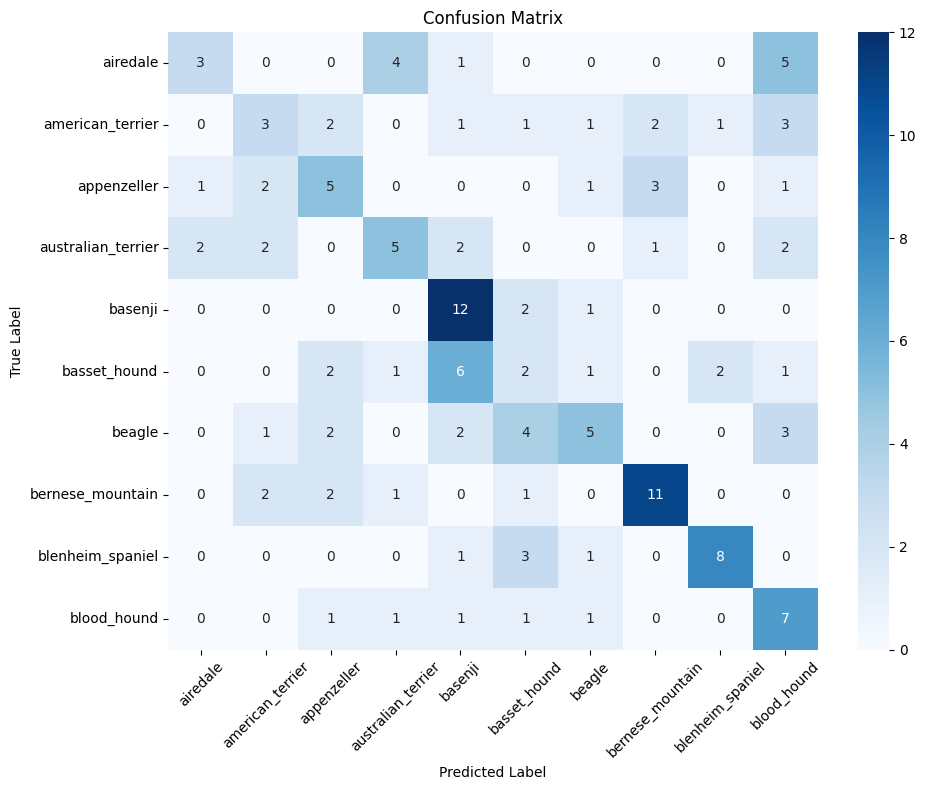


Epoch 16/30
Train Loss: 0.0204
Val Accuracy: 0.4266
Val Precision: 0.4325
Val Recall: 0.4260
Val F1: 0.4127


Epoch 17/30: 100%|██████████| 36/36 [00:59<00:00,  1.66s/it]


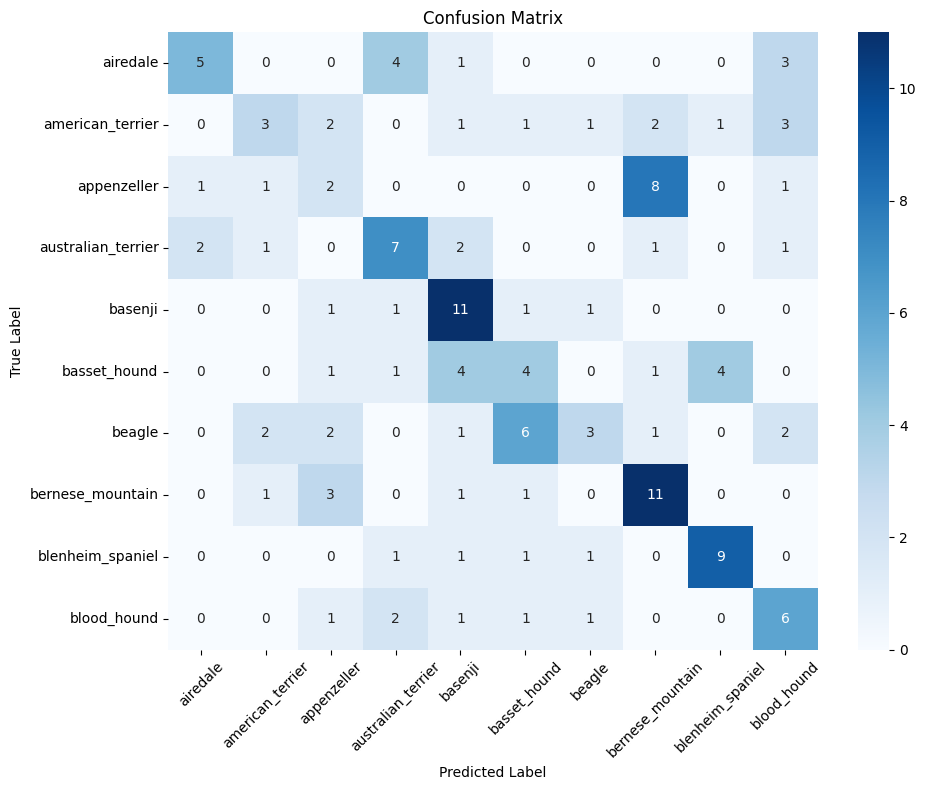


Epoch 17/30
Train Loss: 0.0191
Val Accuracy: 0.4266
Val Precision: 0.4254
Val Recall: 0.4269
Val F1: 0.4103
Epoch 00017: reducing learning rate of group 0 to 3.7500e-05.


Epoch 18/30: 100%|██████████| 36/36 [01:01<00:00,  1.71s/it]


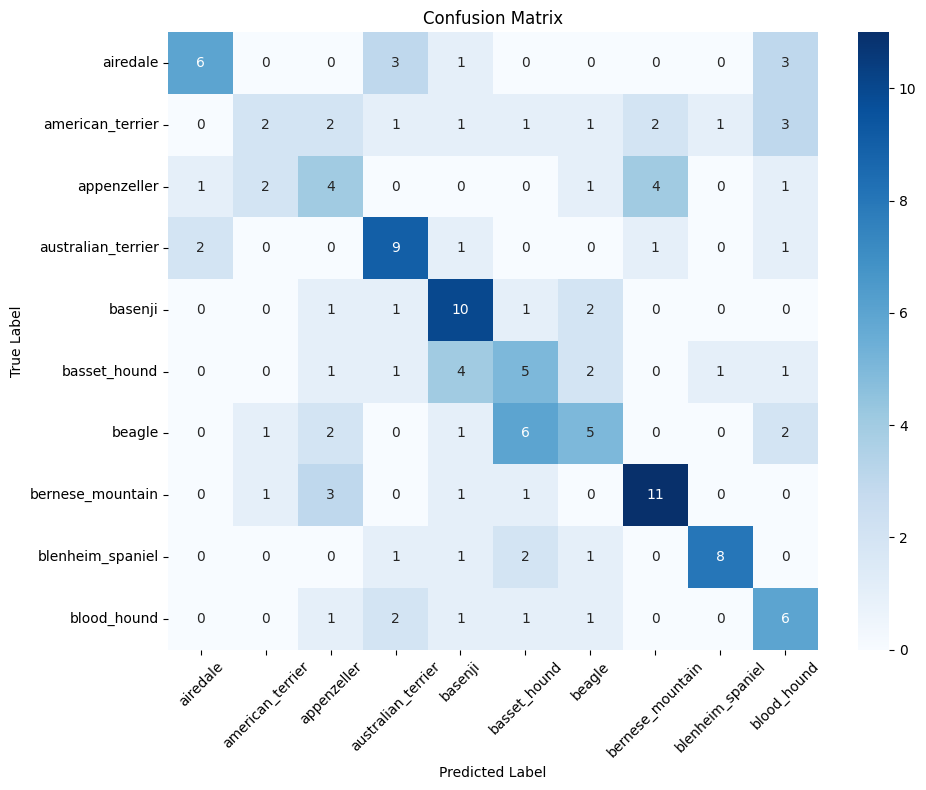


Epoch 18/30
Train Loss: 0.0142
Val Accuracy: 0.4615
Val Precision: 0.4705
Val Recall: 0.4612
Val F1: 0.4544


Epoch 19/30: 100%|██████████| 36/36 [01:02<00:00,  1.73s/it]


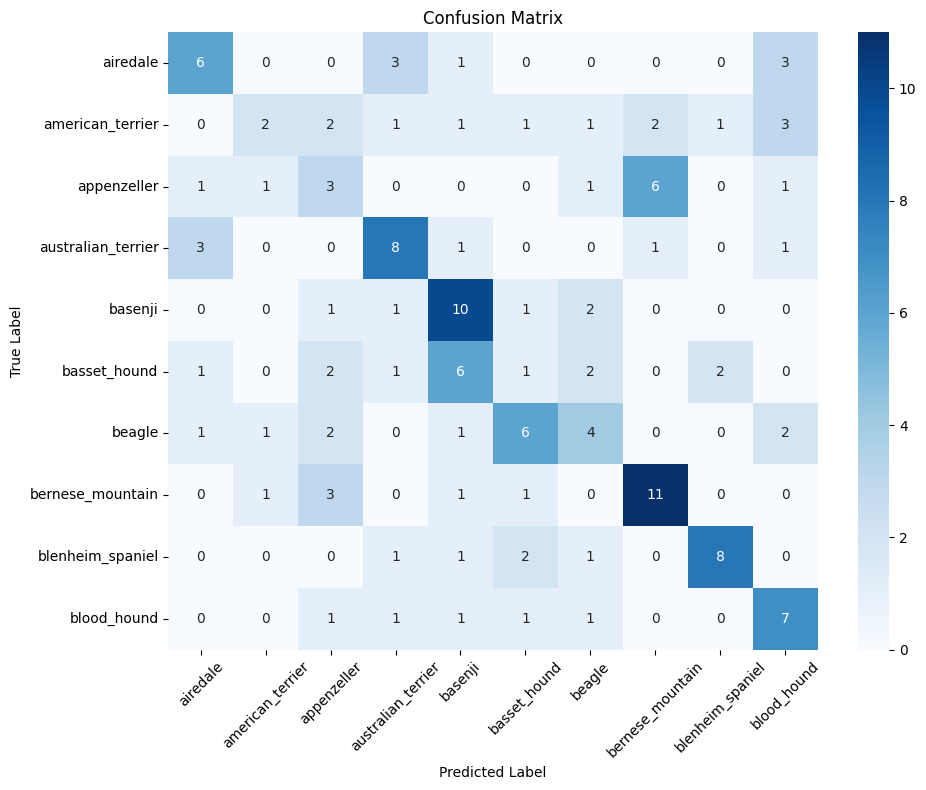


Epoch 19/30
Train Loss: 0.0130
Val Accuracy: 0.4196
Val Precision: 0.4148
Val Recall: 0.4221
Val F1: 0.4064


Epoch 20/30: 100%|██████████| 36/36 [01:01<00:00,  1.70s/it]


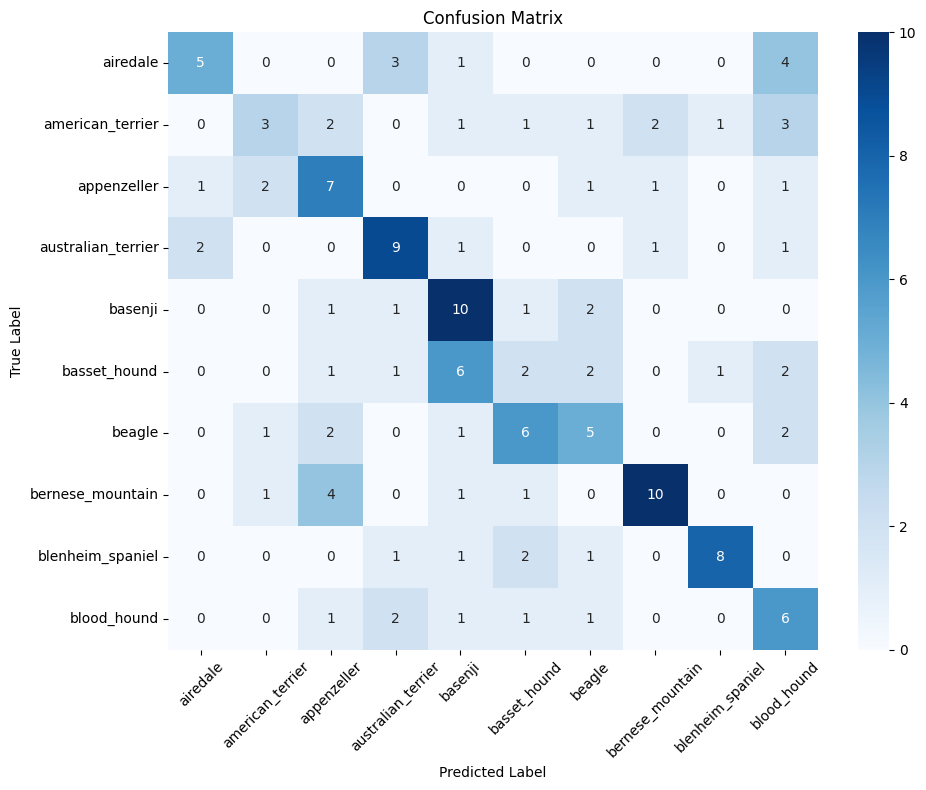


Epoch 20/30
Train Loss: 0.0136
Val Accuracy: 0.4545
Val Precision: 0.4764
Val Recall: 0.4578
Val F1: 0.4520
Epoch 00020: reducing learning rate of group 0 to 1.8750e-05.


Epoch 21/30: 100%|██████████| 36/36 [01:01<00:00,  1.72s/it]


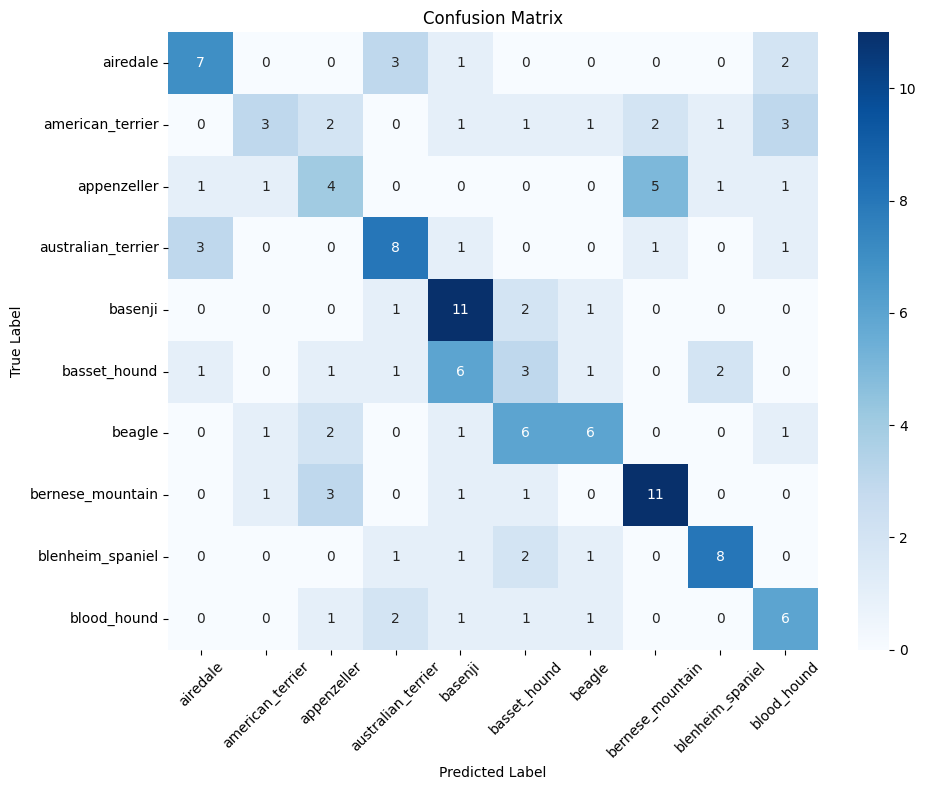


Epoch 21/30
Train Loss: 0.0111
Val Accuracy: 0.4685
Val Precision: 0.4756
Val Recall: 0.4681
Val F1: 0.4600


Epoch 22/30: 100%|██████████| 36/36 [01:02<00:00,  1.74s/it]


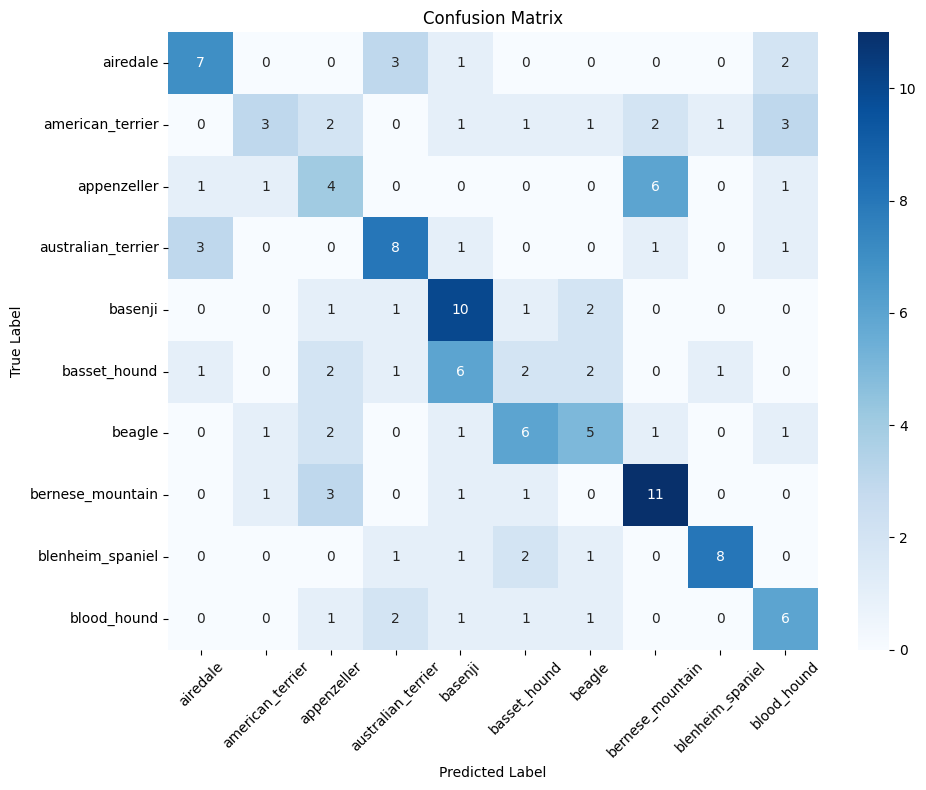


Epoch 22/30
Train Loss: 0.0108
Val Accuracy: 0.4476
Val Precision: 0.4597
Val Recall: 0.4488
Val F1: 0.4424


Epoch 23/30: 100%|██████████| 36/36 [01:01<00:00,  1.71s/it]


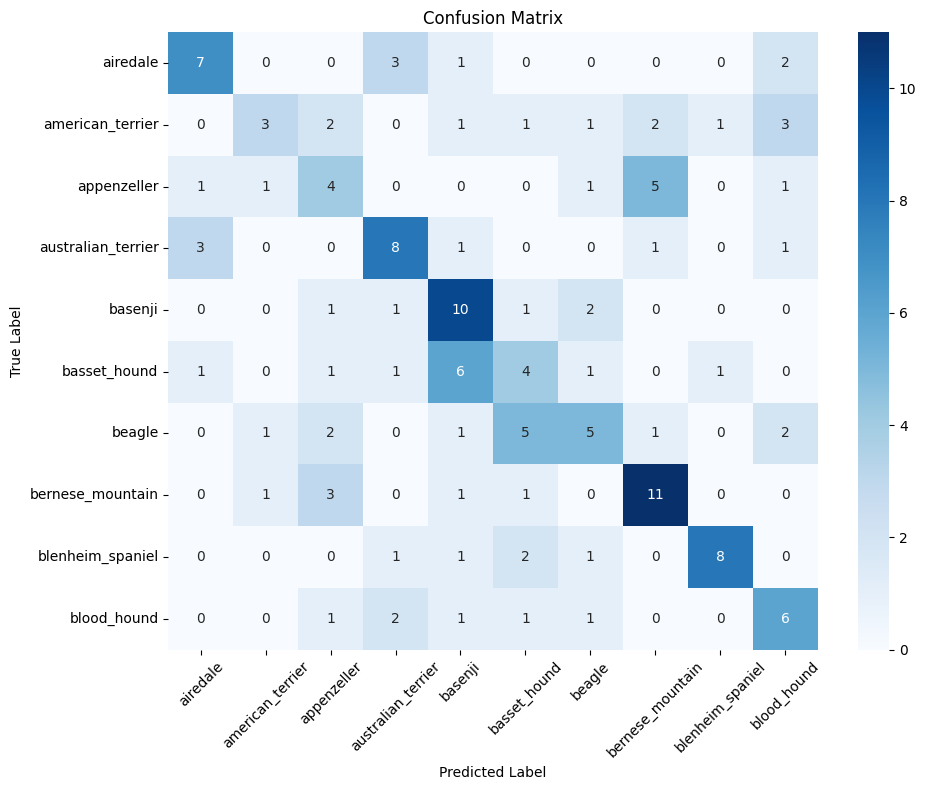


Epoch 23/30
Train Loss: 0.0115
Val Accuracy: 0.4615
Val Precision: 0.4737
Val Recall: 0.4622
Val F1: 0.4562
Epoch 00023: reducing learning rate of group 0 to 9.3750e-06.


Epoch 24/30: 100%|██████████| 36/36 [01:02<00:00,  1.74s/it]


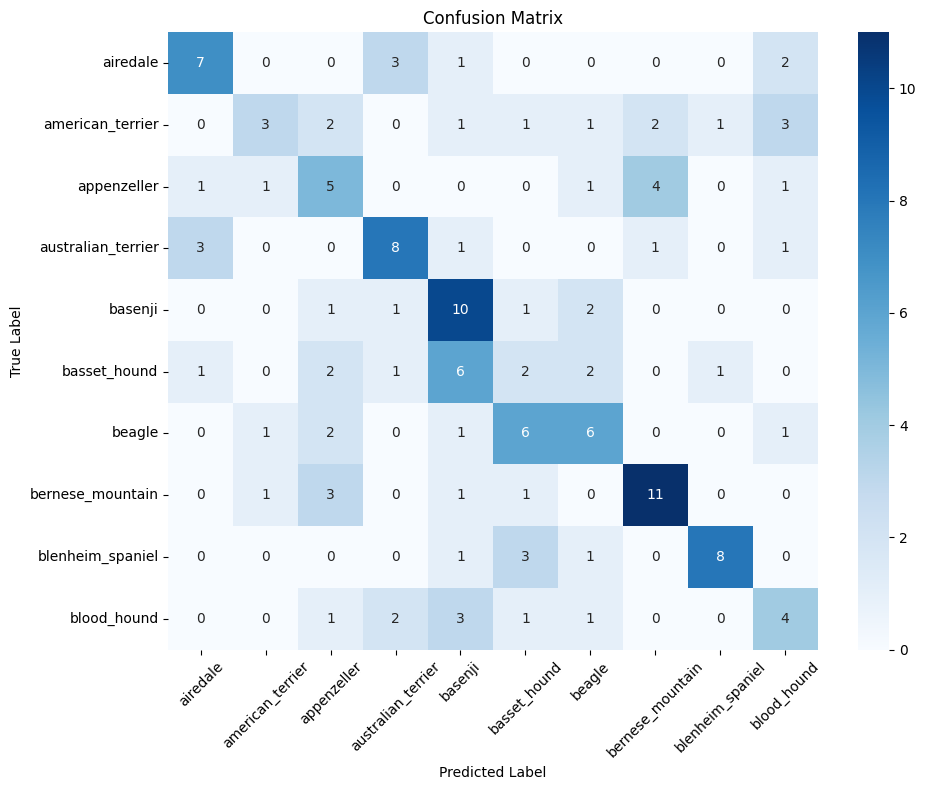


Epoch 24/30
Train Loss: 0.0104
Val Accuracy: 0.4476
Val Precision: 0.4636
Val Recall: 0.4458
Val F1: 0.4435


Epoch 25/30: 100%|██████████| 36/36 [01:00<00:00,  1.69s/it]


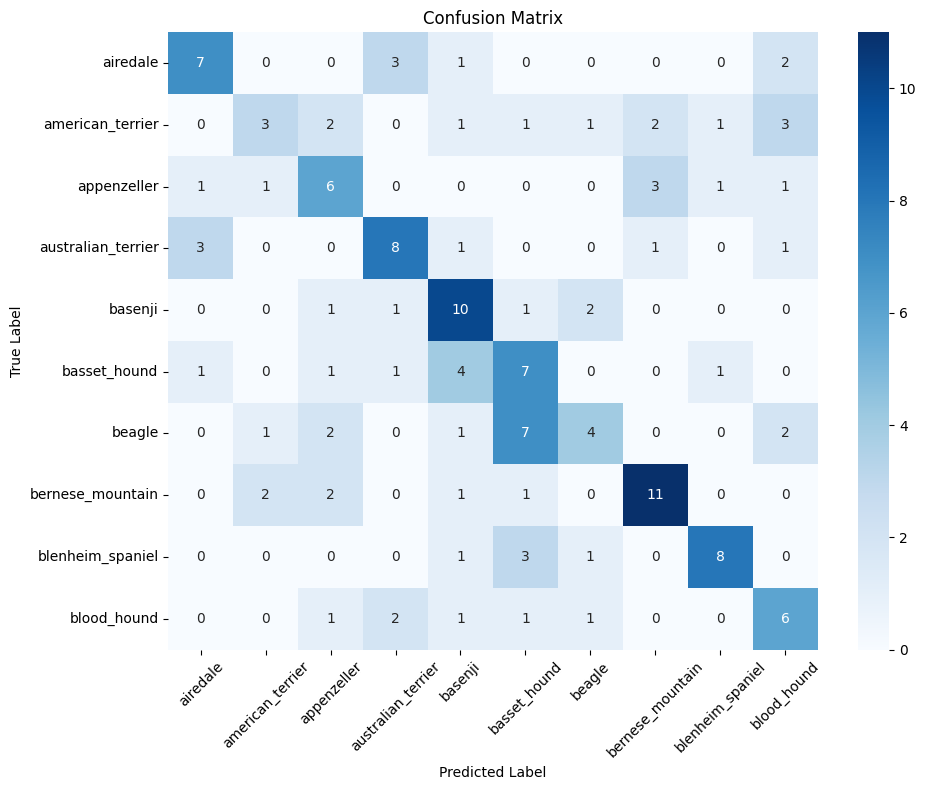


Epoch 25/30
Train Loss: 0.0107
Val Accuracy: 0.4895
Val Precision: 0.4974
Val Recall: 0.4917
Val F1: 0.4836


Epoch 26/30: 100%|██████████| 36/36 [01:00<00:00,  1.69s/it]


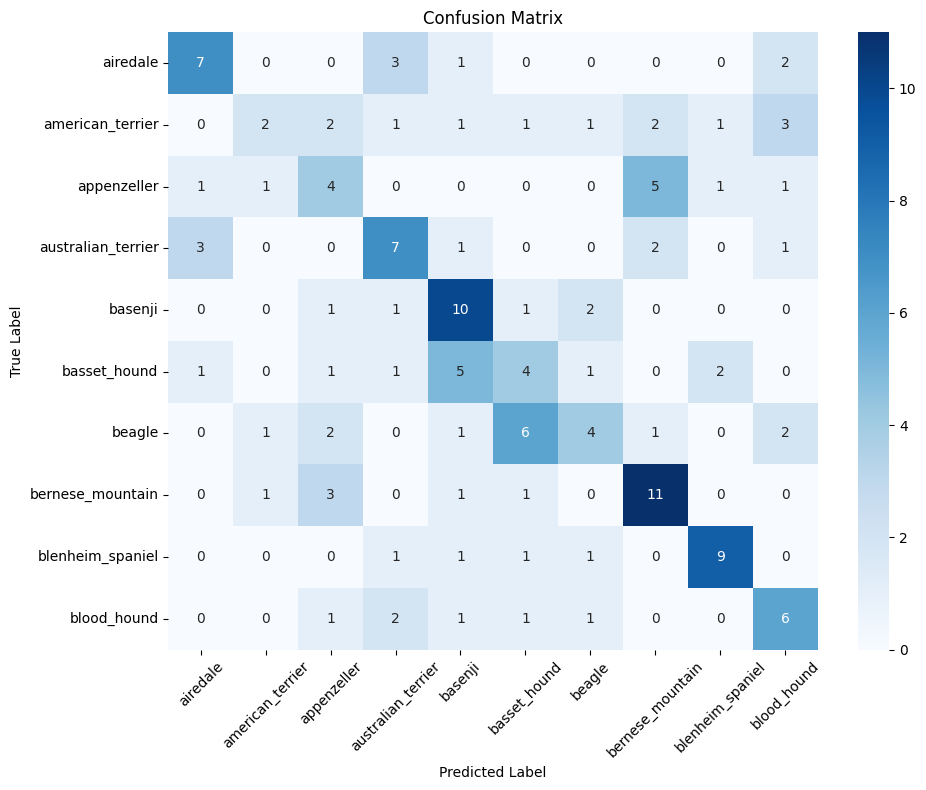


Epoch 26/30
Train Loss: 0.0084
Val Accuracy: 0.4476
Val Precision: 0.4444
Val Recall: 0.4497
Val F1: 0.4353


Epoch 27/30: 100%|██████████| 36/36 [01:12<00:00,  2.01s/it]


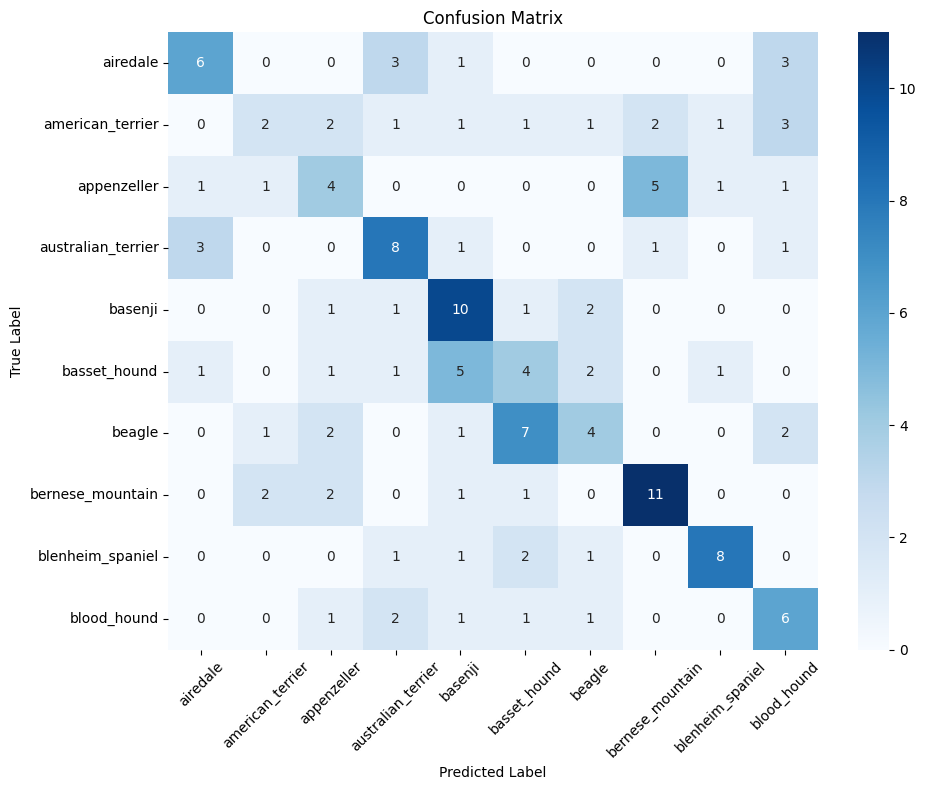


Epoch 27/30
Train Loss: 0.0084
Val Accuracy: 0.4406
Val Precision: 0.4392
Val Recall: 0.4415
Val F1: 0.4306


Epoch 28/30: 100%|██████████| 36/36 [01:05<00:00,  1.82s/it]


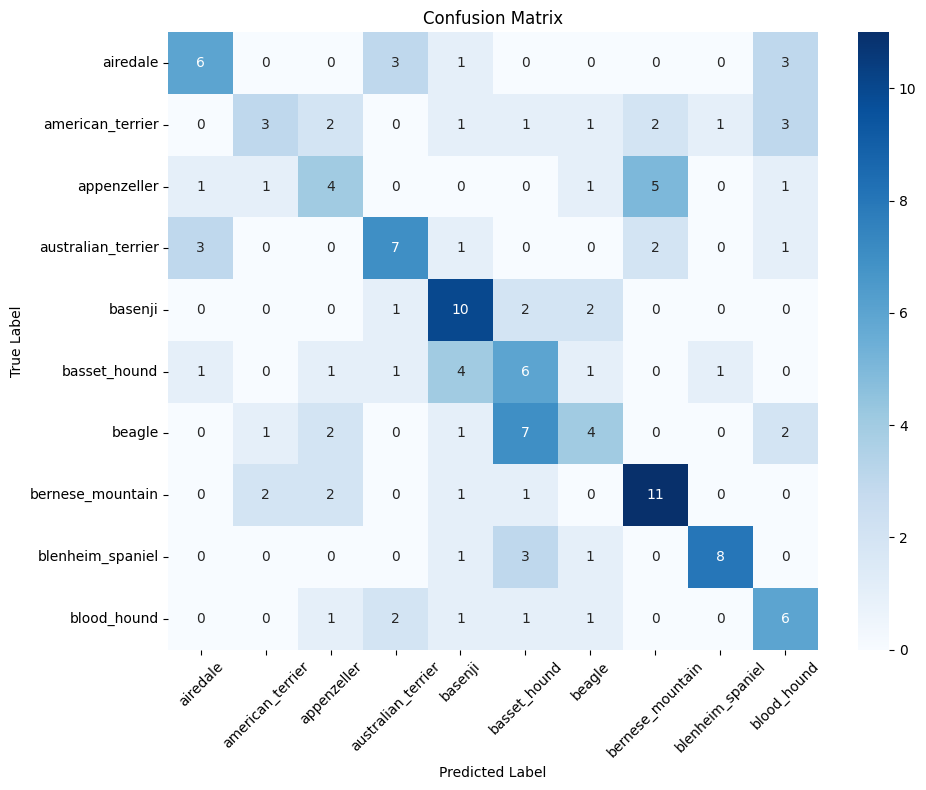


Epoch 28/30
Train Loss: 0.0088
Val Accuracy: 0.4545
Val Precision: 0.4658
Val Recall: 0.4548
Val F1: 0.4499
Epoch 00028: reducing learning rate of group 0 to 4.6875e-06.


Epoch 29/30: 100%|██████████| 36/36 [01:08<00:00,  1.89s/it]


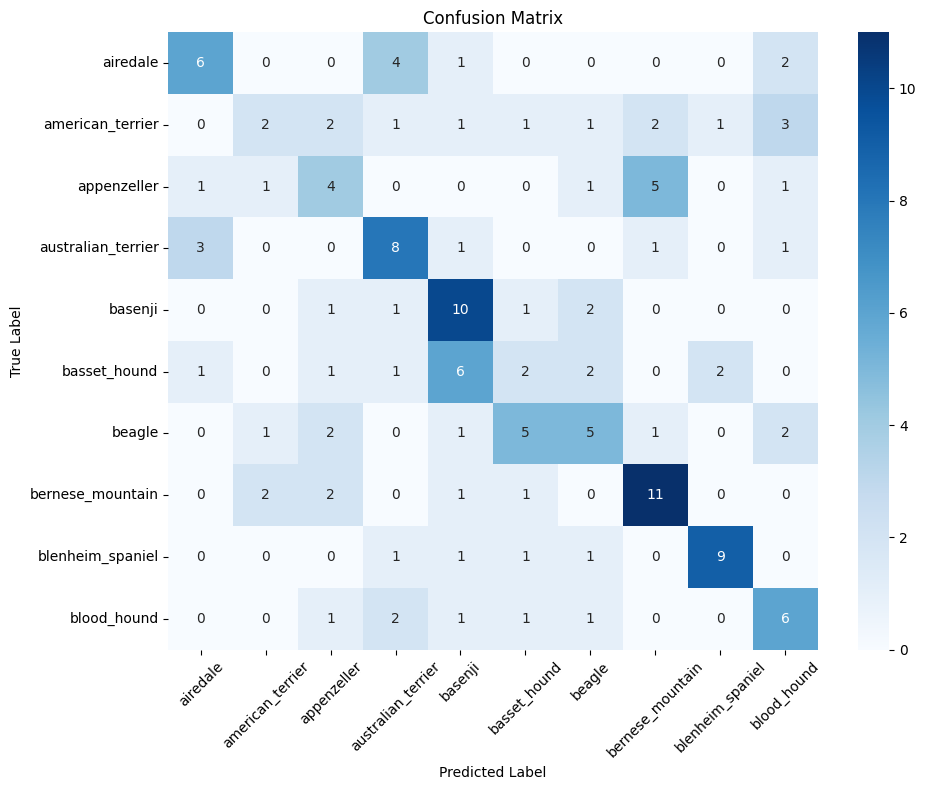


Epoch 29/30
Train Loss: 0.0095
Val Accuracy: 0.4406
Val Precision: 0.4317
Val Recall: 0.4417
Val F1: 0.4275


Epoch 30/30: 100%|██████████| 36/36 [01:04<00:00,  1.79s/it]


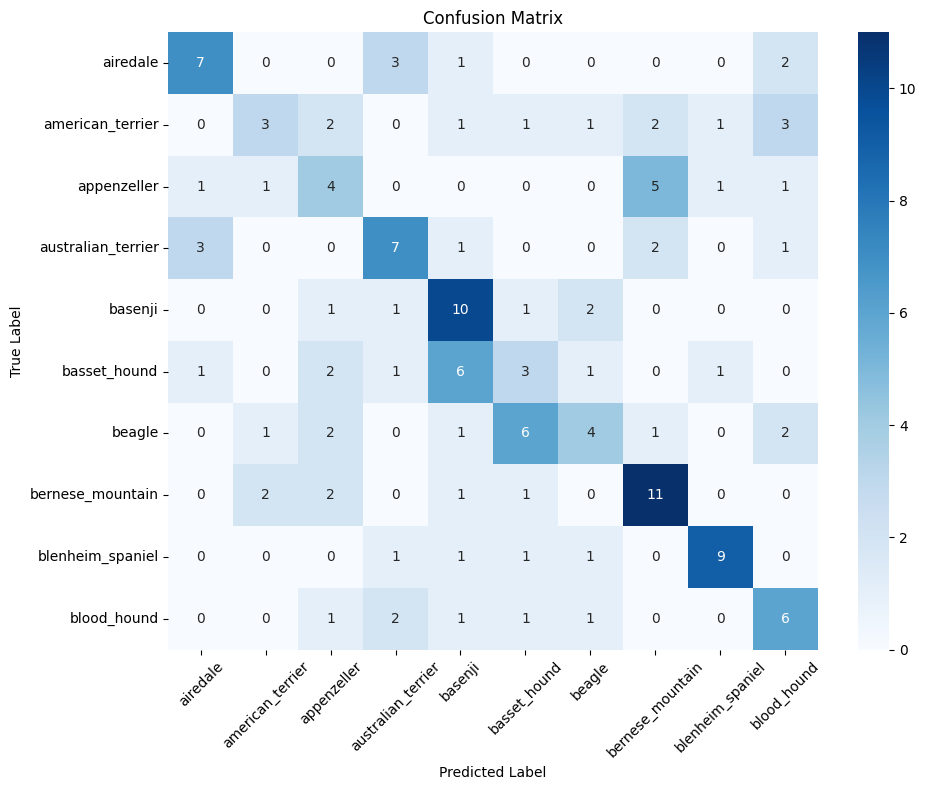


Epoch 30/30
Train Loss: 0.0071
Val Accuracy: 0.4476
Val Precision: 0.4487
Val Recall: 0.4502
Val F1: 0.4398

Model saved successfully!


In [68]:
model = ResNet18(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), 
                      lr=3e-4,  # Уменьшенный LR
                      weight_decay=1e-5)  # Усиленная регуляризация

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',  # Следим за увеличением F1-score
    factor=0.5,  # Уменьшаем LR в 2 раза
    patience=2,  # Ждём 2 эпохи без улучшений
    verbose=True  # Выводим сообщения
)

best_val_f1 = 0.0

for epoch in range(epochs):
    # Обучение
    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Валидация
    val_accuracy, val_precision, val_recall, val_f1, val_cm = evaluate(model, val_loader, class_names=full_dataset.classes)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader):.4f}")
    print(f"Val Accuracy: {val_accuracy:.4f}")
    print(f"Val Precision: {val_precision:.4f}")
    print(f"Val Recall: {val_recall:.4f}")
    print(f"Val F1: {val_f1:.4f}")
    scheduler.step(val_f1)  
    
    best_val_f1 = max(best_val_f1, val_f1)

torch.save(model.state_dict(), "resnet18_best_model.pth")
print("\nModel saved successfully!")

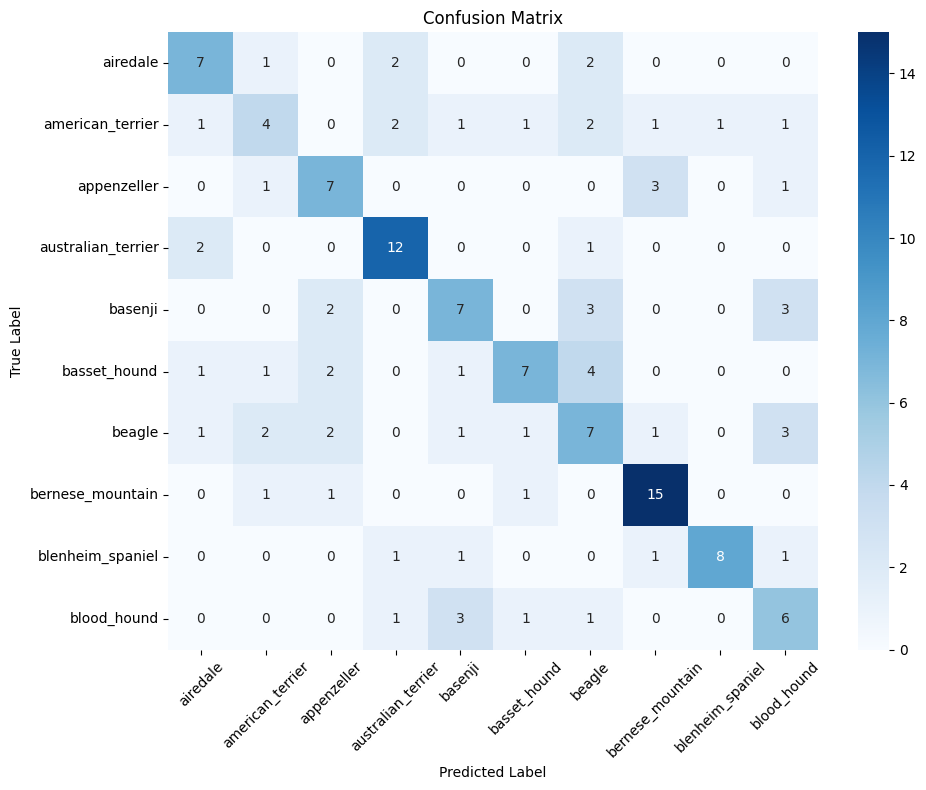


Test Results:
Accuracy: 0.5556
Precision: 0.5640
Recall: 0.5545
F1 Score: 0.5528


In [69]:
# Тестирования модели
test_accuracy, test_precision, test_recall, test_f1, test_cm = evaluate(
    model, 
    test_loader,
    class_names=full_dataset.classes  
)

print("\nTest Results:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1 Score: {test_f1:.4f}")

#### ВЫВОД: модель показывает неплохие результаты для данного датасета при обучении с нуля. Потенциально, если увеличить датасет хотя бы в 2 раза, то метрики получаться еще выше, но в данной ситуации лучше подобрать другую, более подходящую, архитектуру

### 2. Улучшенная структура с последовательными слоями с регуляризацией (постепенное уменьшение размерности, Dropout для борьбы с переобучением, дополнительные ReLU-активации)
#### модель ImprovedResNet
#### Функция потерь - CrossEntropyLoss
#### Оптимизатор - SGD

#### Аугментации - RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ColorJitter, ToTensor, Normalize, RandomAffine, RandomPerspective

In [76]:
class ImprovedResNet18(ResNet):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__(block, num_blocks, num_classes)
        
        # Изменяем avgpool для получения нужной размерности
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        
        # Оптимизированная FC-часть
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512, 384),  # 512 - выход из сверточных слоев
            nn.BatchNorm1d(384),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(384, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)  
        x = self.fc(x)
        return x

def ImprovedResNet18(num_classes=10):
    return ImprovedResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [77]:
# Аугментации
train_transform_2 = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

val_transform_2 = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),])

full_dataset_2 = DogDataset(
    root_dir="C:/Users/User/.cache/kagglehub/datasets/darshanthakare/dog-breeds-image-dataset/versions/1/cropped_dogs10",
    transform=train_transform_2)

train_idx_2, temp_idx_2 = train_test_split(
    range(len(full_dataset_2)),
    test_size=0.2,
    stratify=full_dataset_2.labels,  # Важно для баланса классов
    random_state=42)


val_idx_2, test_idx_2 = train_test_split(
    temp_idx_2,
    test_size=0.5,
    stratify=[full_dataset_2.labels[i] for i in temp_idx],
    random_state=42)

train_dataset_2 = torch.utils.data.Subset(full_dataset_2, train_idx_2)
val_dataset_2 = torch.utils.data.Subset(full_dataset_2, val_idx_2)
test_dataset_2 = torch.utils.data.Subset(full_dataset_2, test_idx_2)

val_dataset_2.dataset.transform = val_transform_2
test_dataset_2.dataset.transform = val_transform_2

train_loader_2 = DataLoader(train_dataset_2, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader_2 = DataLoader(val_dataset_2, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader_2 = DataLoader(test_dataset_2, batch_size=batch_size, shuffle=False, num_workers=0)

Epoch 1/30: 100%|██████████| 36/36 [00:57<00:00,  1.59s/it]


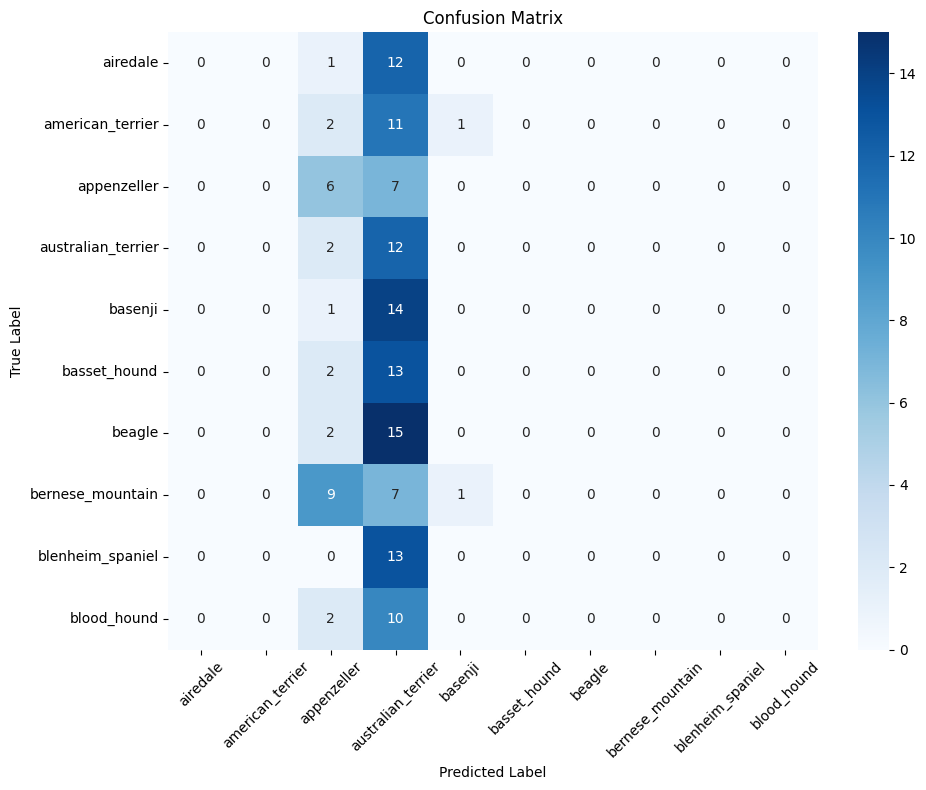


Epoch 1/30
Train Loss: 2.3473
Val Accuracy: 0.1259
Val Precision: 0.0327
Val Recall: 0.1319
Val F1: 0.0488


Epoch 2/30: 100%|██████████| 36/36 [00:59<00:00,  1.64s/it]


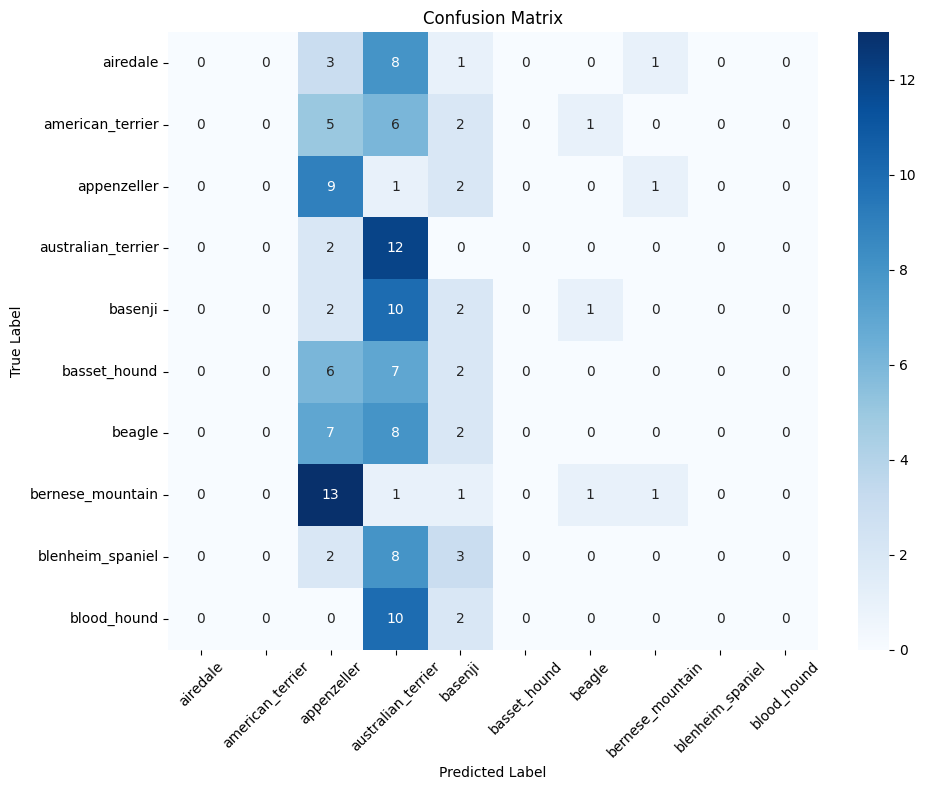


Epoch 2/30
Train Loss: 2.2582
Val Accuracy: 0.1678
Val Precision: 0.0804
Val Recall: 0.1742
Val F1: 0.0798


Epoch 3/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


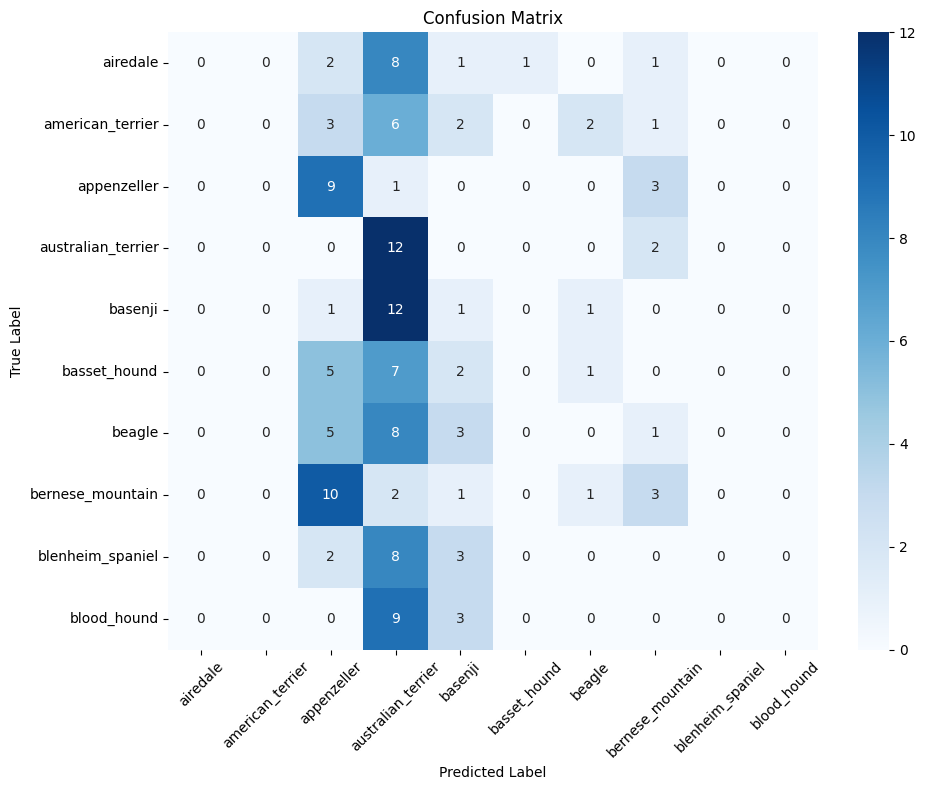


Epoch 3/30
Train Loss: 2.2005
Val Accuracy: 0.1748
Val Precision: 0.0743
Val Recall: 0.1793
Val F1: 0.0915


Epoch 4/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


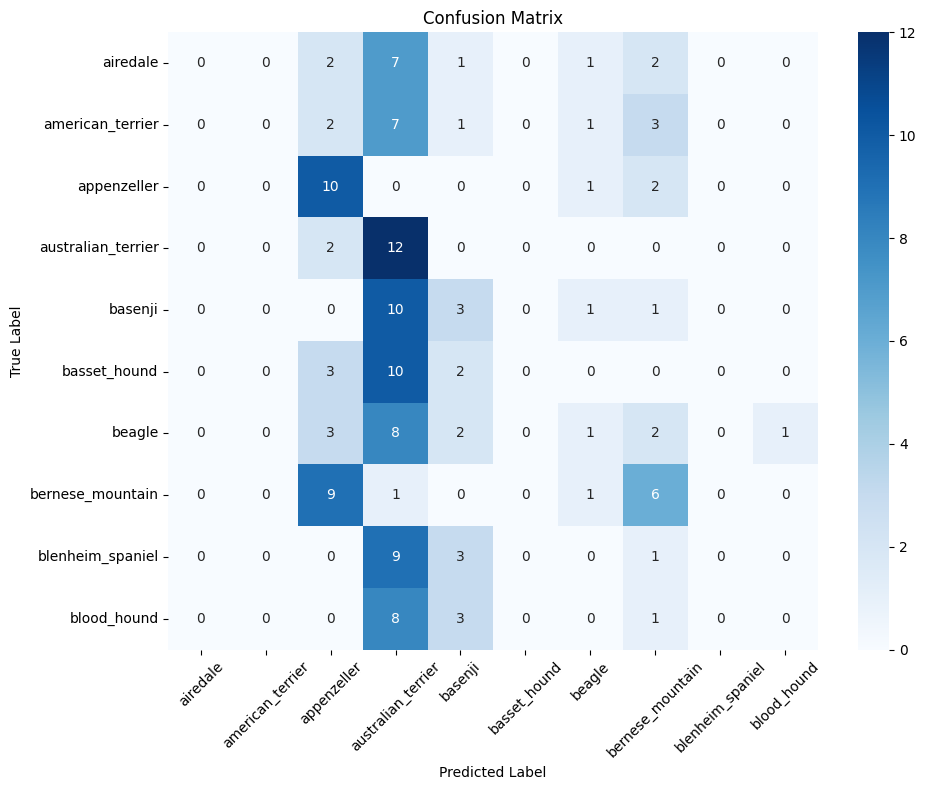


Epoch 4/30
Train Loss: 2.1502
Val Accuracy: 0.2238
Val Precision: 0.1189
Val Recall: 0.2238
Val F1: 0.1363


Epoch 5/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


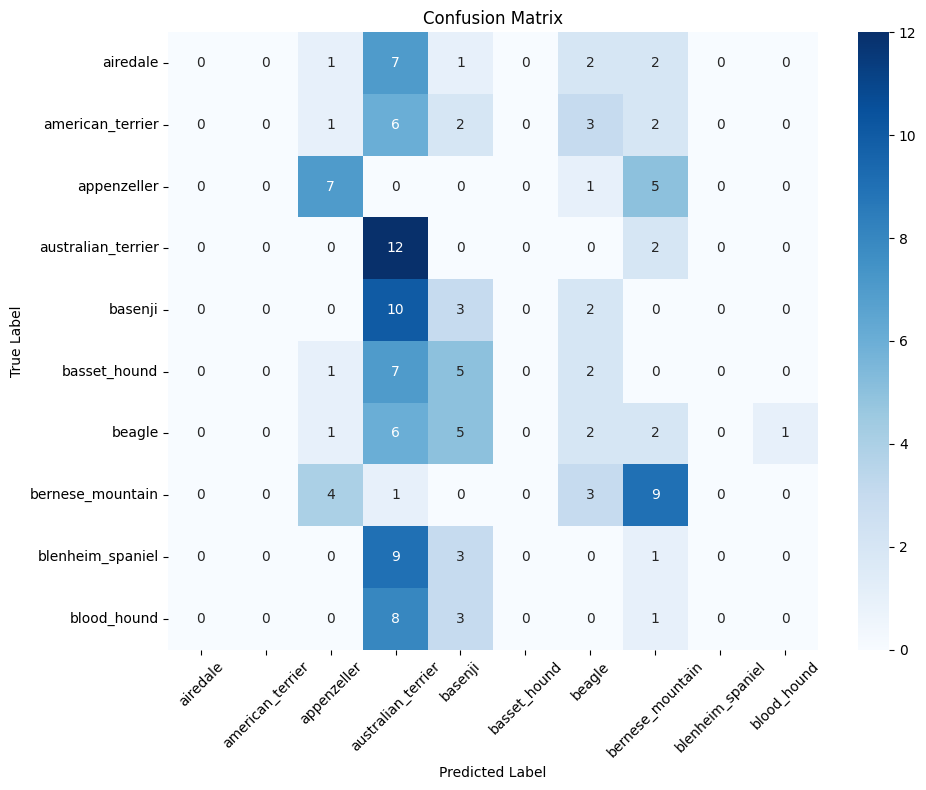


Epoch 5/30
Train Loss: 2.1082
Val Accuracy: 0.2308
Val Precision: 0.1293
Val Recall: 0.2243
Val F1: 0.1526


Epoch 6/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


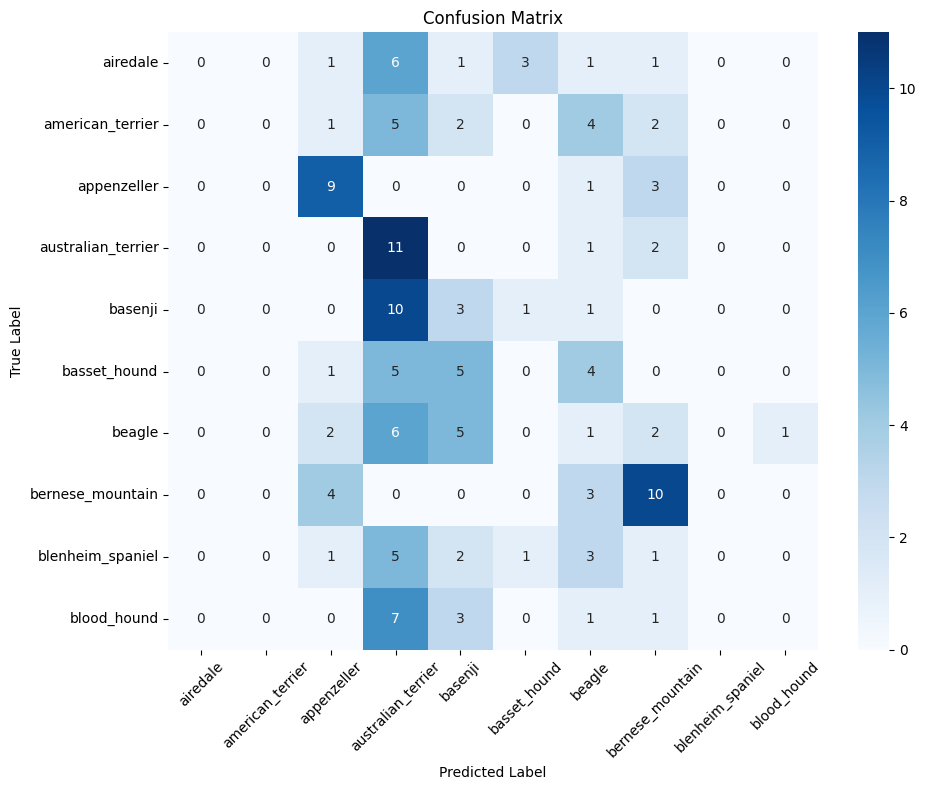


Epoch 6/30
Train Loss: 2.0719
Val Accuracy: 0.2378
Val Precision: 0.1321
Val Recall: 0.2325
Val F1: 0.1615


Epoch 7/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


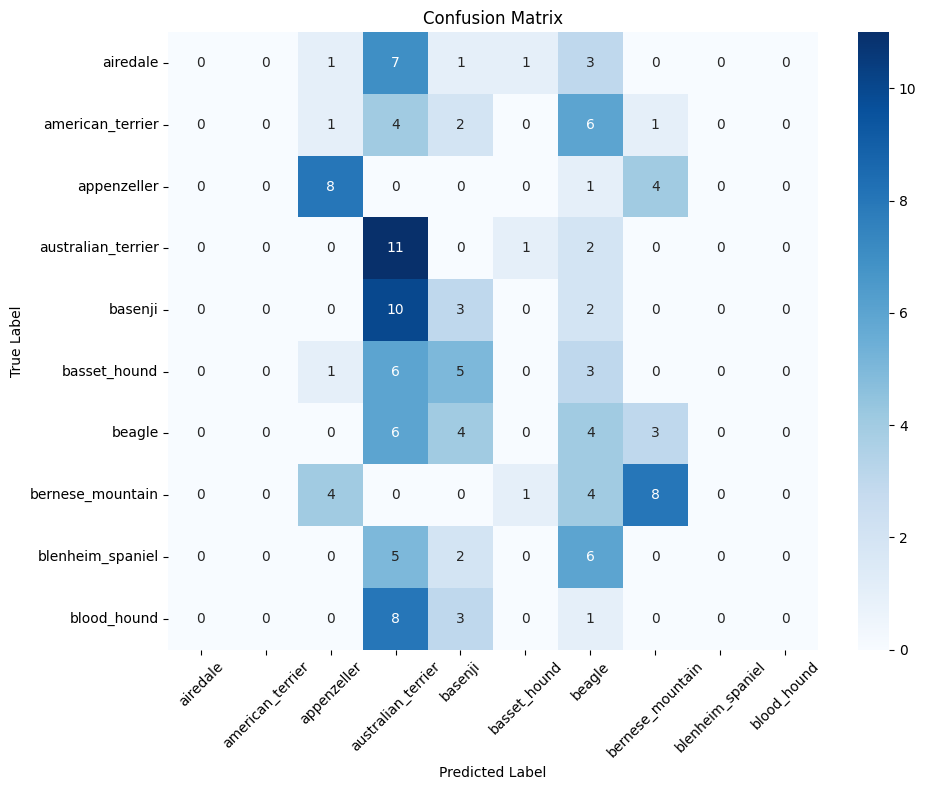


Epoch 7/30
Train Loss: 2.0377
Val Accuracy: 0.2378
Val Precision: 0.1501
Val Recall: 0.2307
Val F1: 0.1701


Epoch 8/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


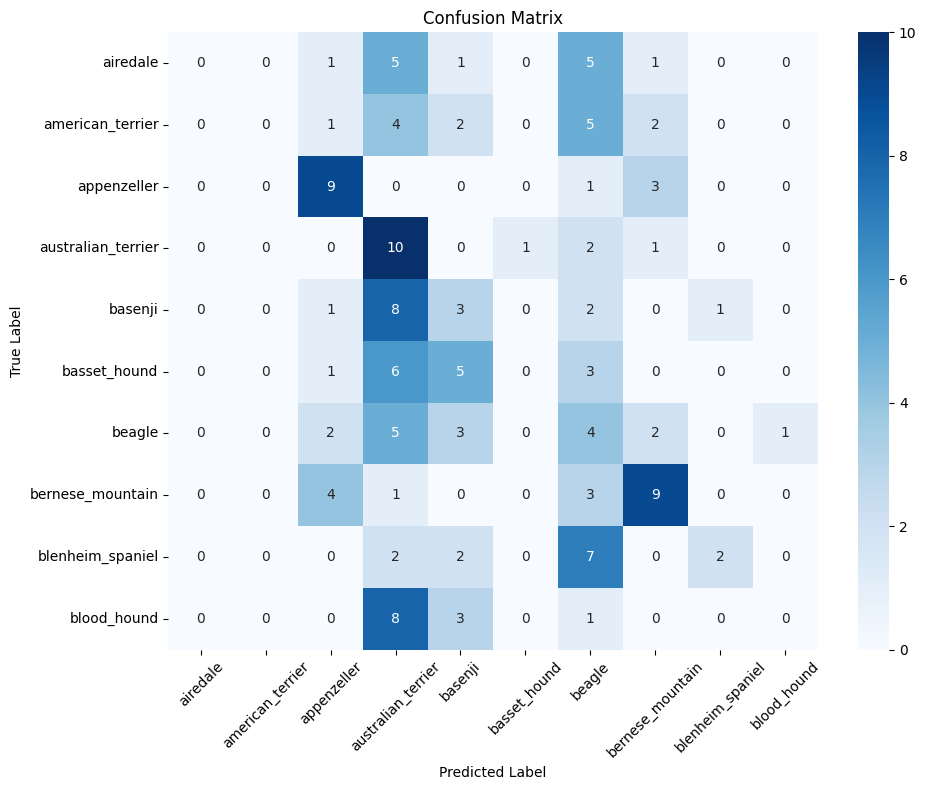


Epoch 8/30
Train Loss: 2.0029
Val Accuracy: 0.2587
Val Precision: 0.2124
Val Recall: 0.2525
Val F1: 0.1981


Epoch 9/30: 100%|██████████| 36/36 [00:59<00:00,  1.66s/it]


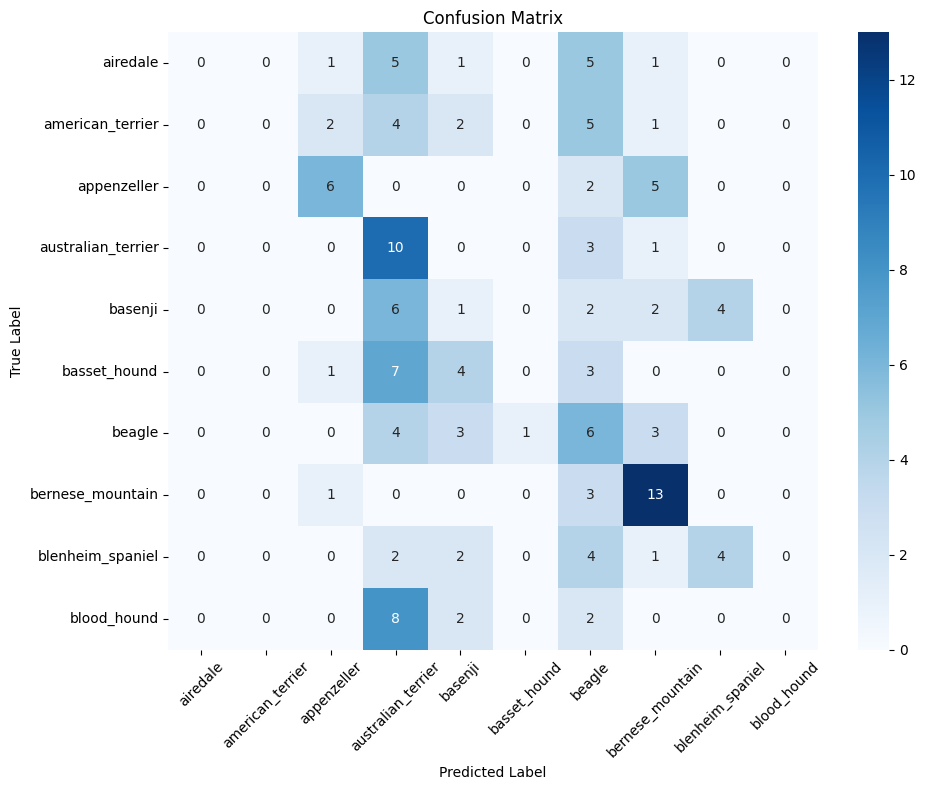


Epoch 9/30
Train Loss: 1.9603
Val Accuracy: 0.2797
Val Precision: 0.1982
Val Recall: 0.2668
Val F1: 0.2103


Epoch 10/30: 100%|██████████| 36/36 [01:00<00:00,  1.69s/it]


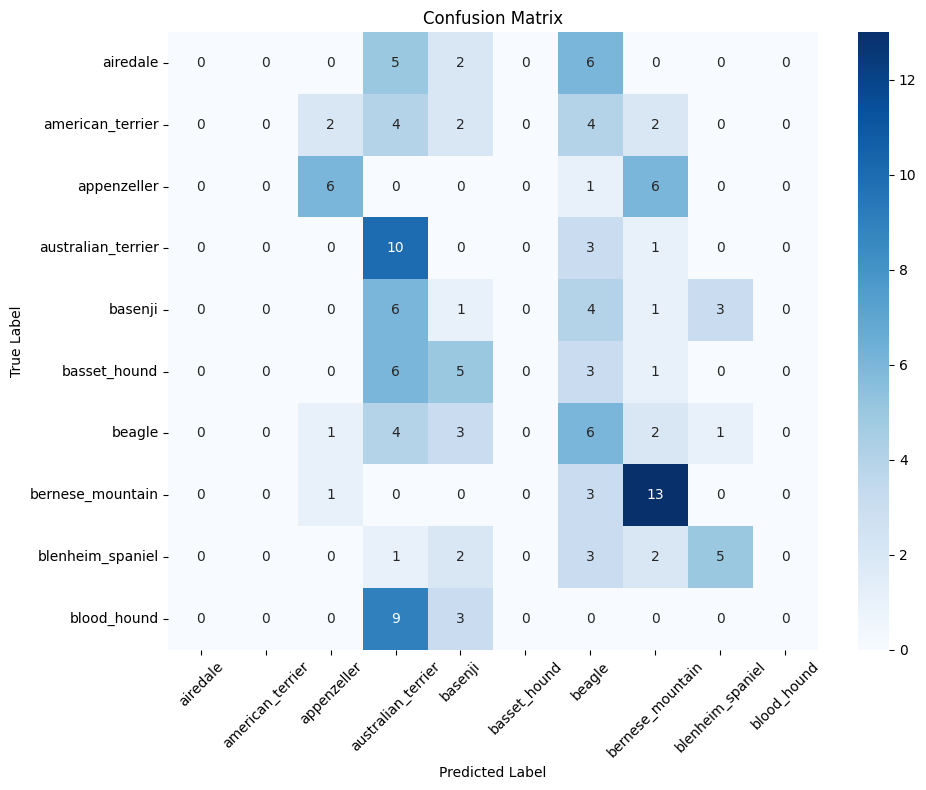


Epoch 10/30
Train Loss: 1.9383
Val Accuracy: 0.2867
Val Precision: 0.2079
Val Recall: 0.2745
Val F1: 0.2194


Epoch 11/30: 100%|██████████| 36/36 [01:00<00:00,  1.68s/it]


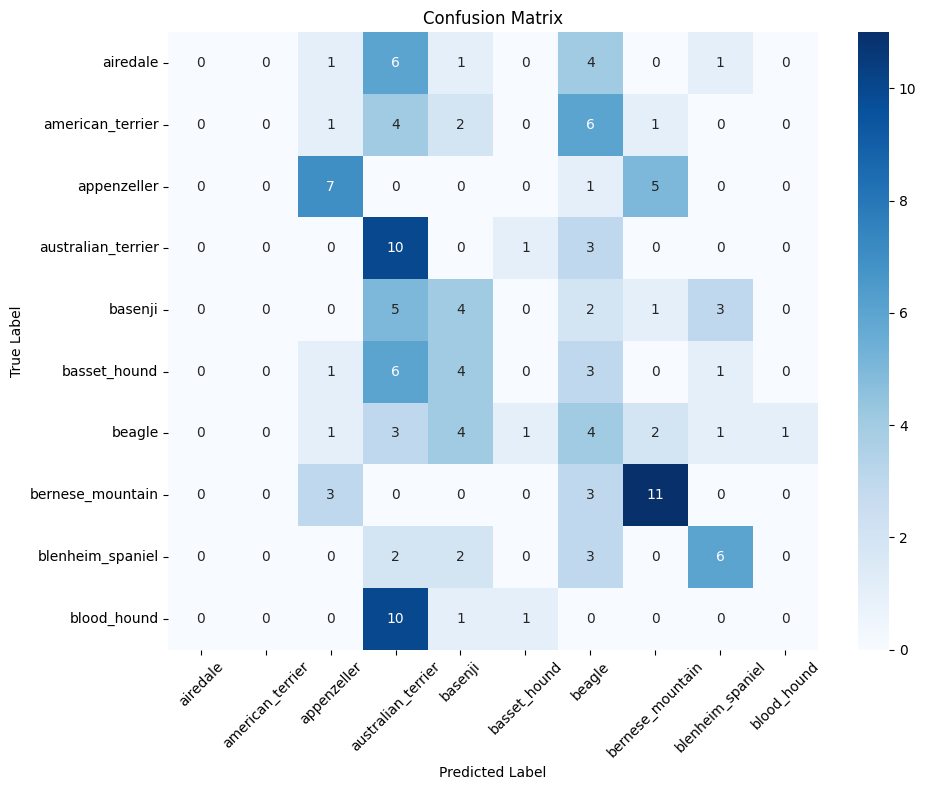


Epoch 11/30
Train Loss: 1.8957
Val Accuracy: 0.2937
Val Precision: 0.2128
Val Recall: 0.2863
Val F1: 0.2343


Epoch 12/30: 100%|██████████| 36/36 [00:59<00:00,  1.64s/it]


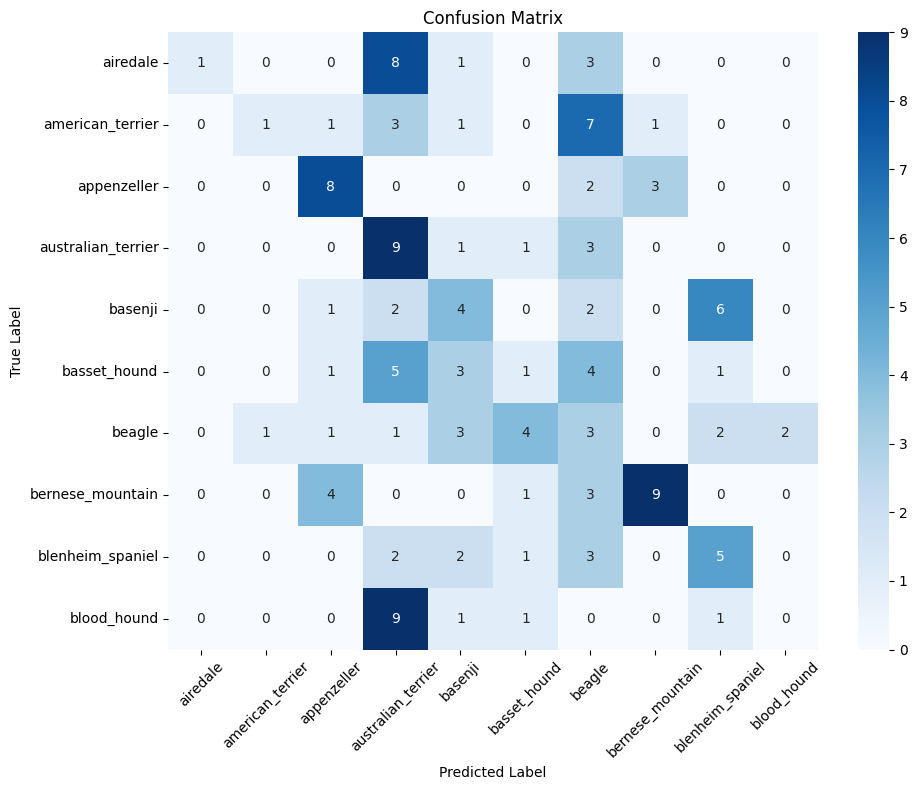


Epoch 12/30
Train Loss: 1.8634
Val Accuracy: 0.2867
Val Precision: 0.3718
Val Recall: 0.2830
Val F1: 0.2585


Epoch 13/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


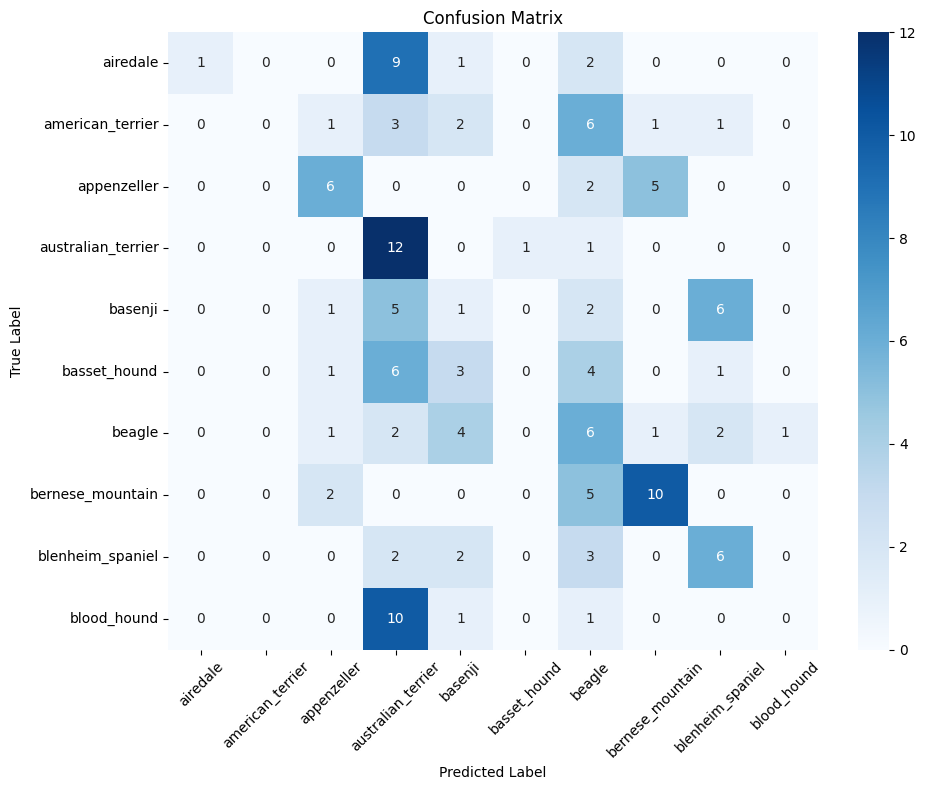


Epoch 13/30
Train Loss: 1.8176
Val Accuracy: 0.2937
Val Precision: 0.2967
Val Recall: 0.2865
Val F1: 0.2320


Epoch 14/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


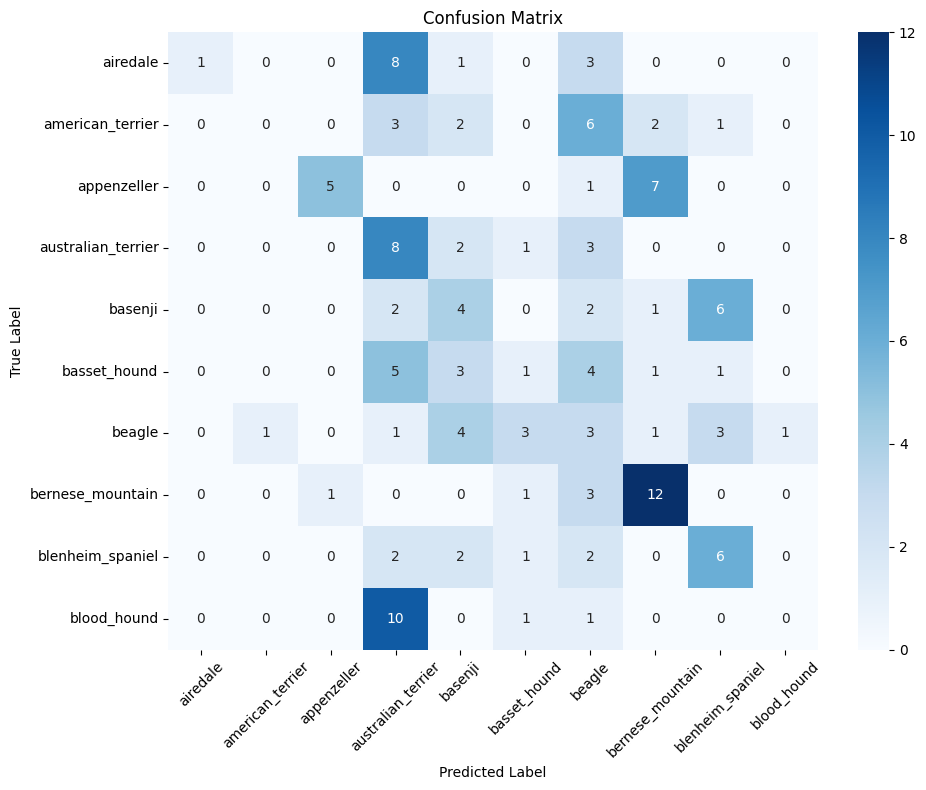


Epoch 14/30
Train Loss: 1.7726
Val Accuracy: 0.2797
Val Precision: 0.3346
Val Recall: 0.2710
Val F1: 0.2419


Epoch 15/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


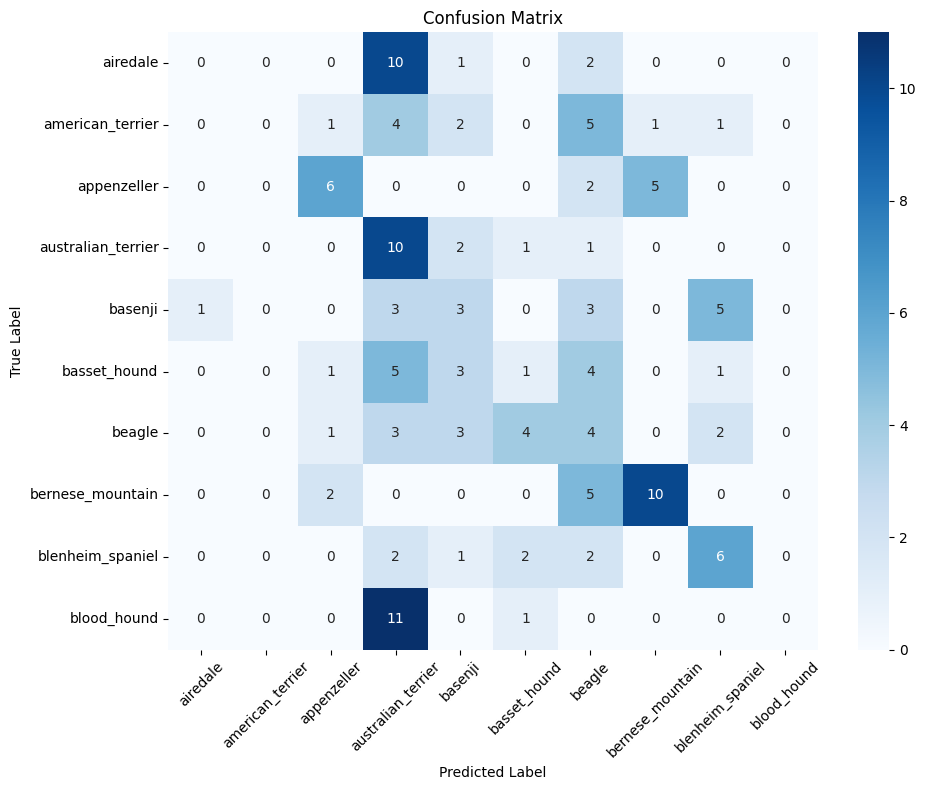


Epoch 15/30
Train Loss: 1.7185
Val Accuracy: 0.2797
Val Precision: 0.2233
Val Recall: 0.2728
Val F1: 0.2318


Epoch 16/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


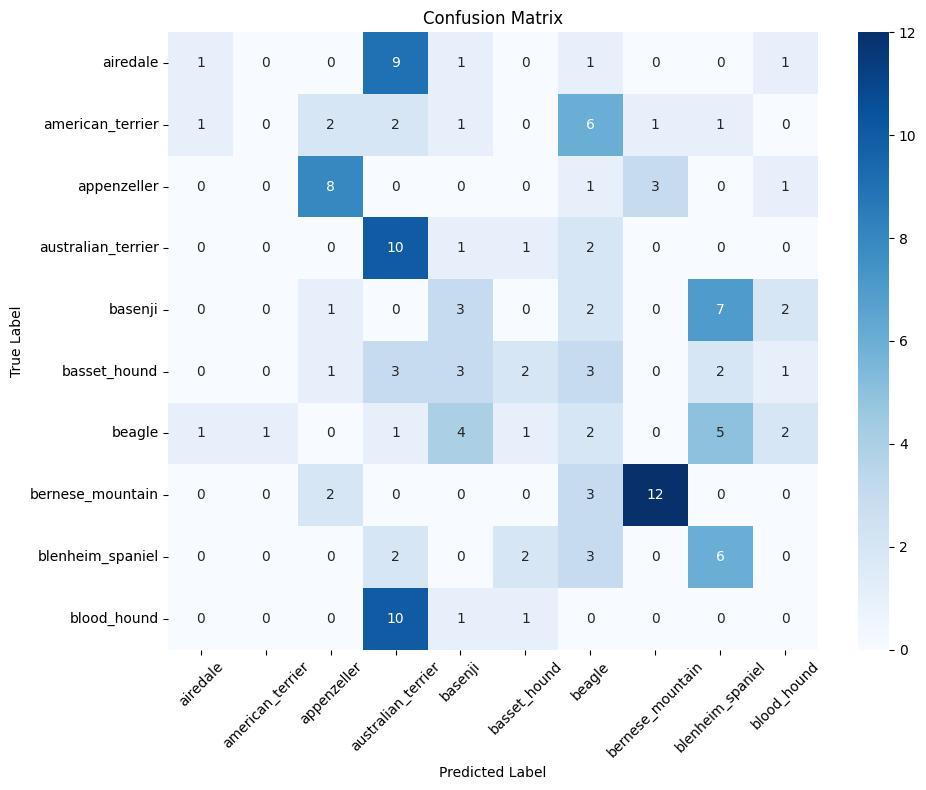


Epoch 16/30
Train Loss: 1.6995
Val Accuracy: 0.3077
Val Precision: 0.2798
Val Recall: 0.3025
Val F1: 0.2679


Epoch 17/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


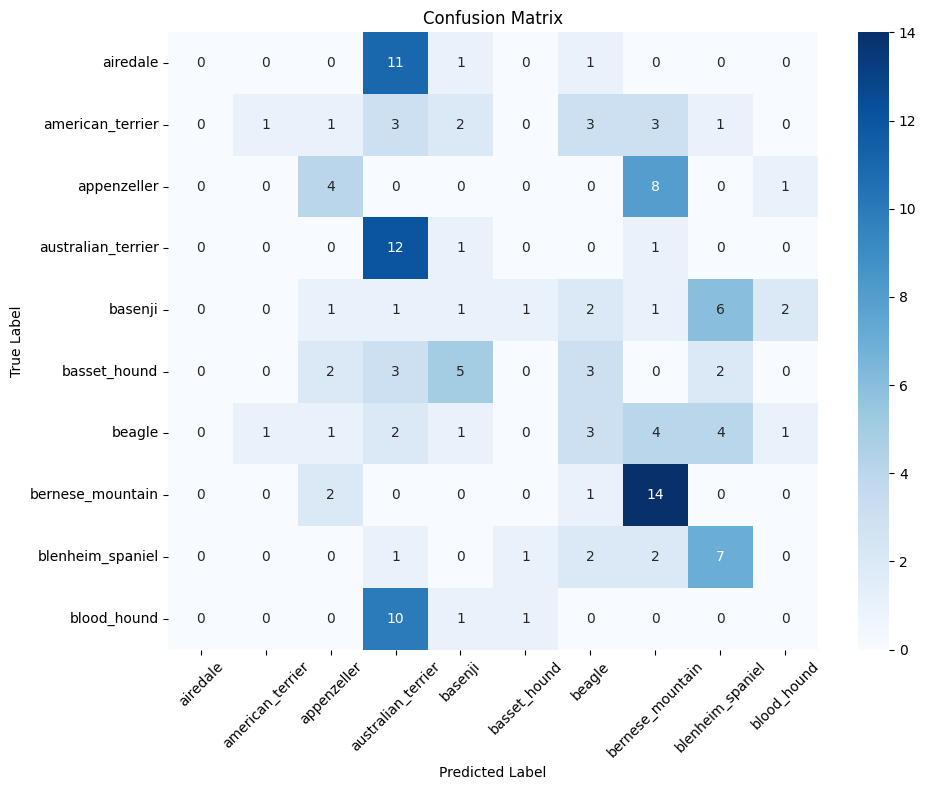


Epoch 17/30
Train Loss: 1.6521
Val Accuracy: 0.2937
Val Precision: 0.2200
Val Recall: 0.2841
Val F1: 0.2125


Epoch 18/30: 100%|██████████| 36/36 [00:59<00:00,  1.64s/it]


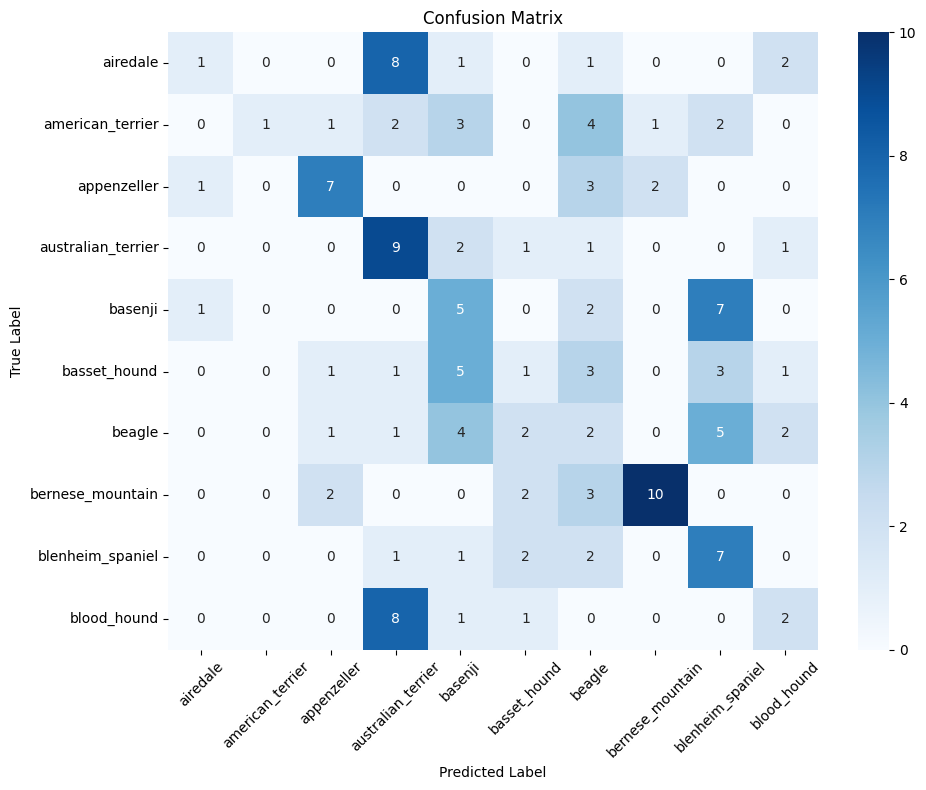


Epoch 18/30
Train Loss: 1.6123
Val Accuracy: 0.3147
Val Precision: 0.3961
Val Recall: 0.3141
Val F1: 0.2931


Epoch 19/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


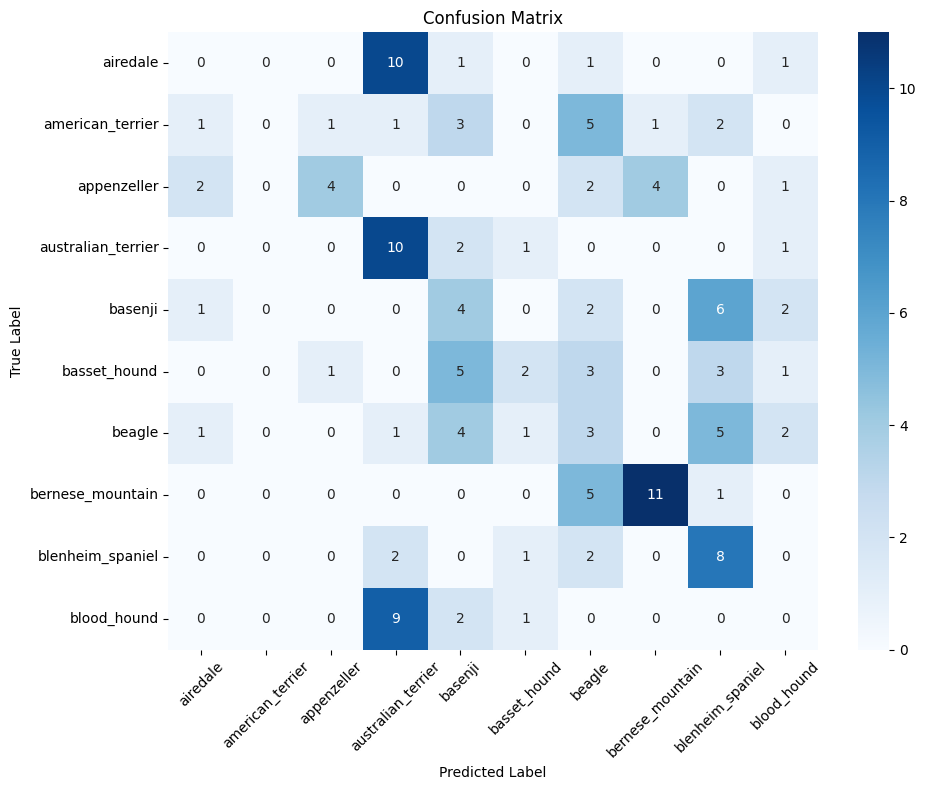


Epoch 19/30
Train Loss: 1.5534
Val Accuracy: 0.2937
Val Precision: 0.2631
Val Recall: 0.2861
Val F1: 0.2497


Epoch 20/30: 100%|██████████| 36/36 [00:58<00:00,  1.62s/it]


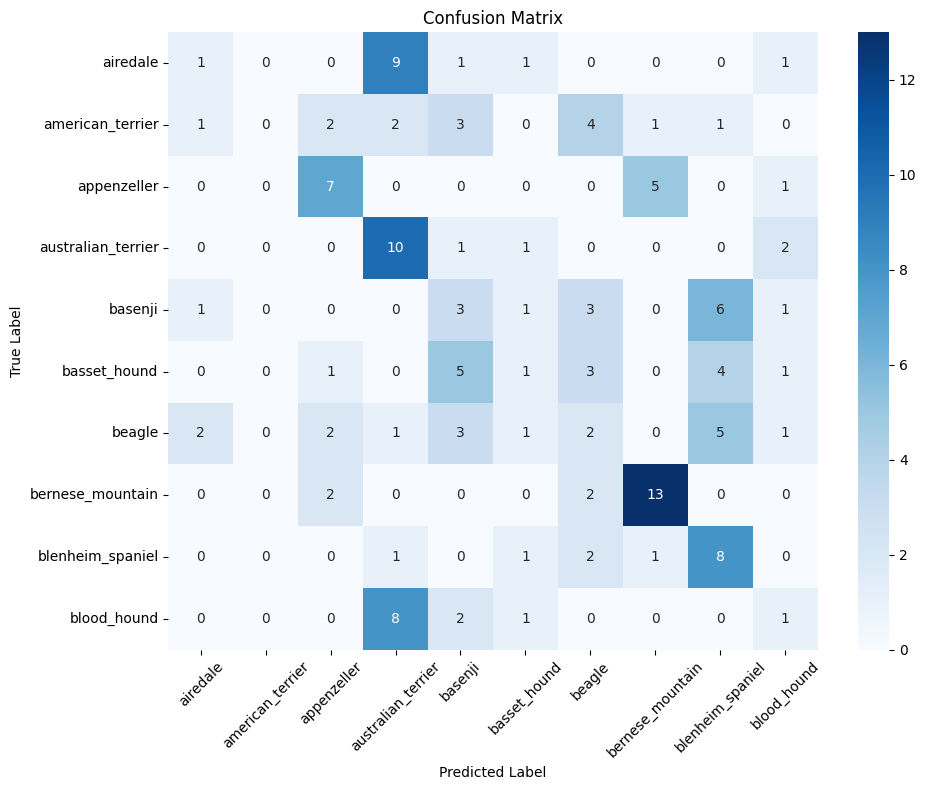


Epoch 20/30
Train Loss: 1.5273
Val Accuracy: 0.3217
Val Precision: 0.2565
Val Recall: 0.3177
Val F1: 0.2703


Epoch 21/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


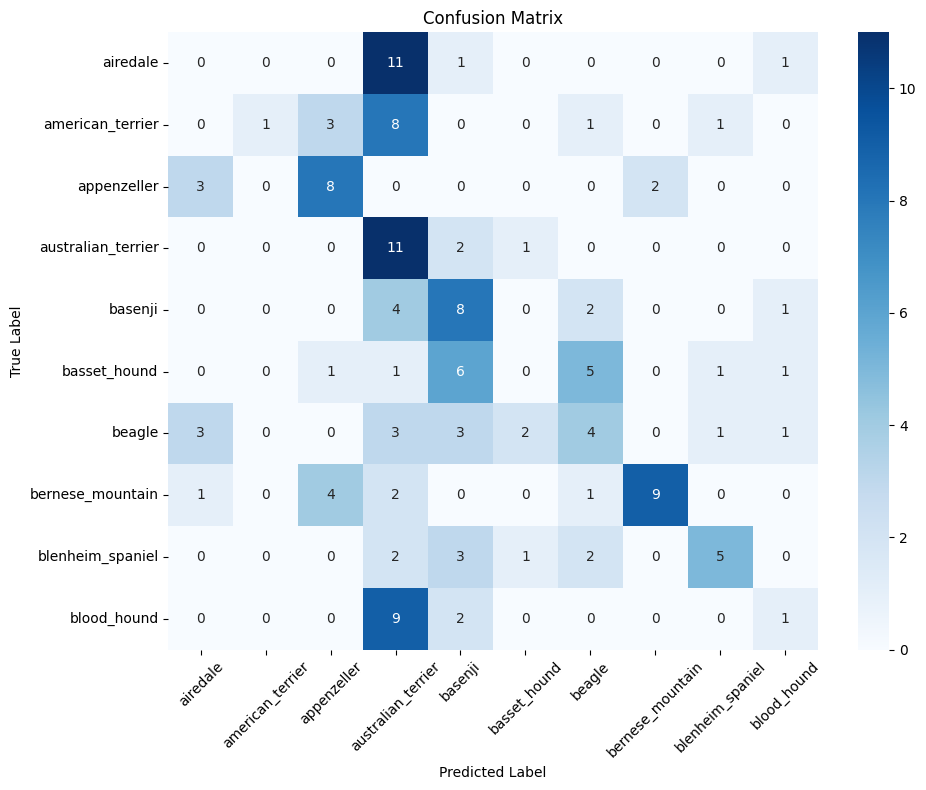


Epoch 21/30
Train Loss: 1.4777
Val Accuracy: 0.3287
Val Precision: 0.3946
Val Recall: 0.3239
Val F1: 0.2910


Epoch 22/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


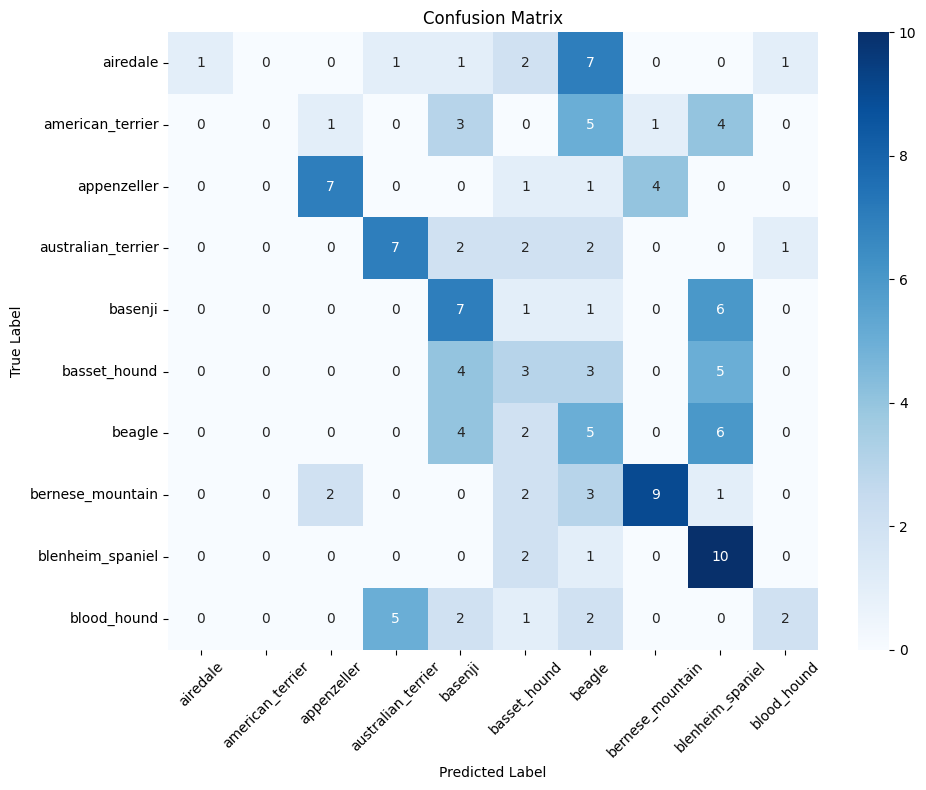


Epoch 22/30
Train Loss: 1.4547
Val Accuracy: 0.3566
Val Precision: 0.4352
Val Recall: 0.3541
Val F1: 0.3320


Epoch 23/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


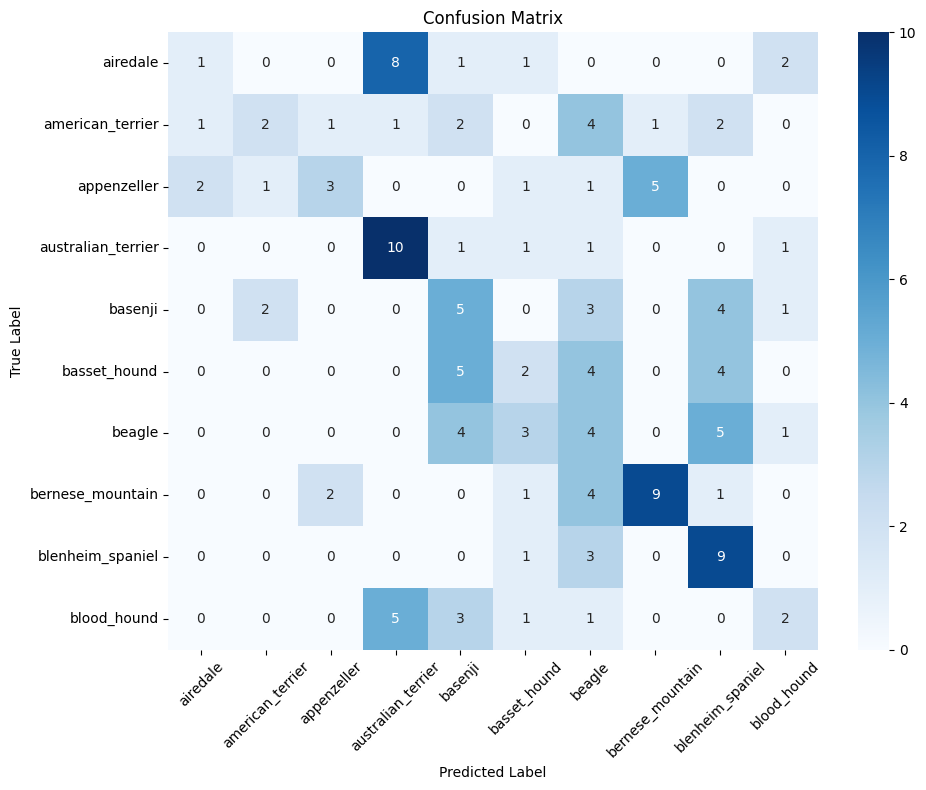


Epoch 23/30
Train Loss: 1.4020
Val Accuracy: 0.3287
Val Precision: 0.3392
Val Recall: 0.3255
Val F1: 0.3039


Epoch 24/30: 100%|██████████| 36/36 [00:58<00:00,  1.63s/it]


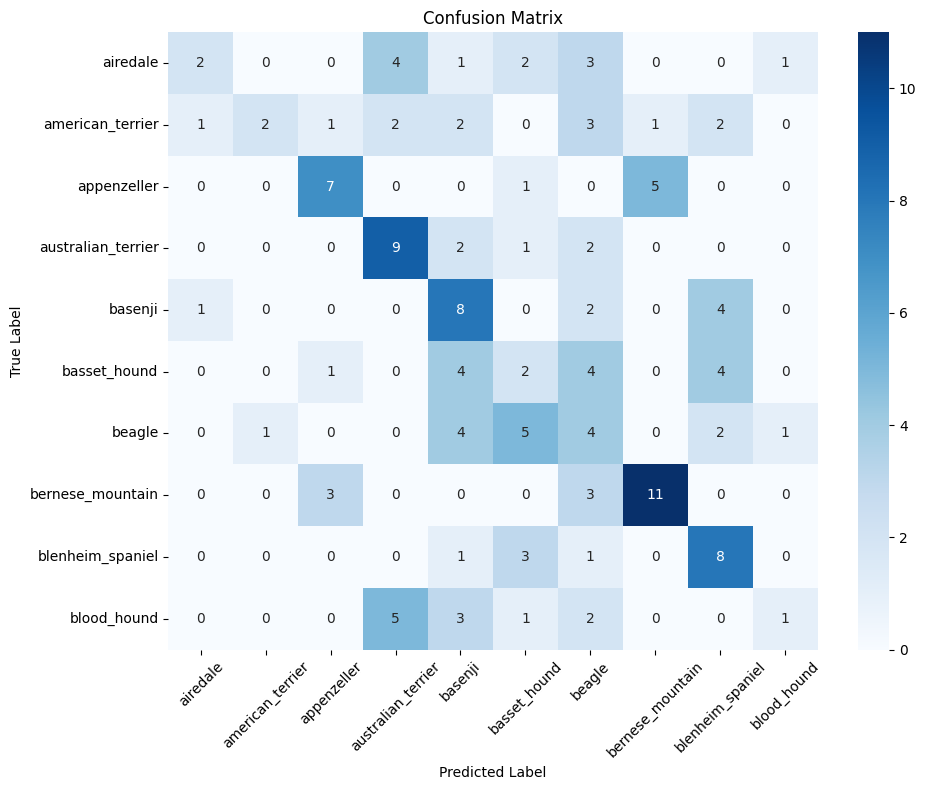


Epoch 24/30
Train Loss: 1.3781
Val Accuracy: 0.3776
Val Precision: 0.4200
Val Recall: 0.3726
Val F1: 0.3554


Epoch 25/30: 100%|██████████| 36/36 [01:07<00:00,  1.86s/it]


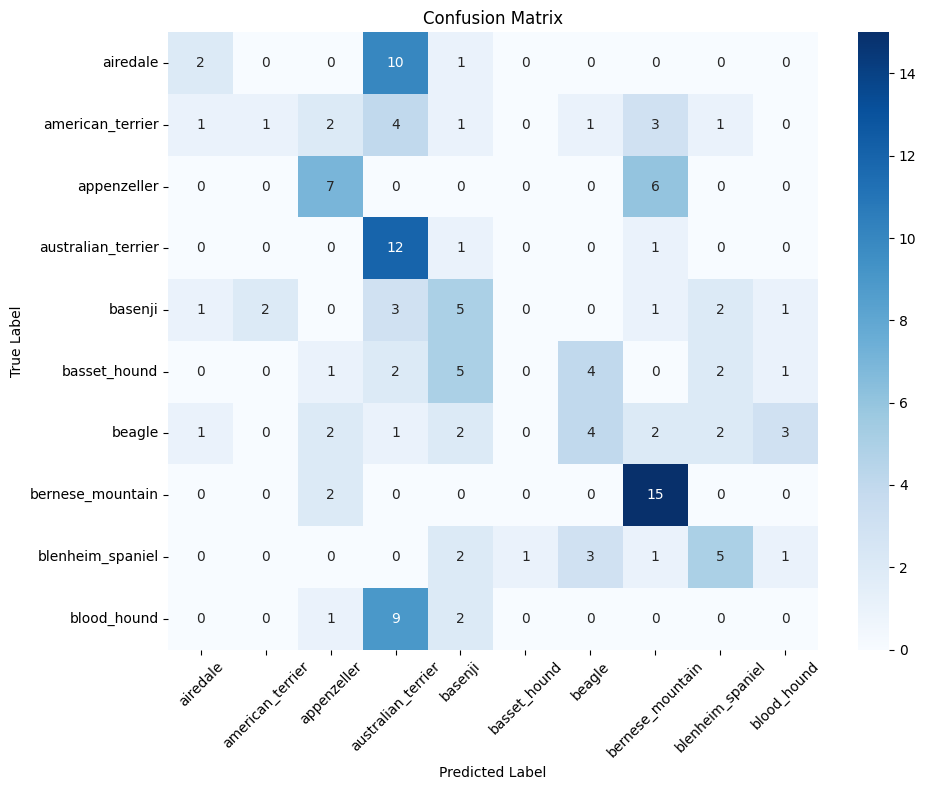


Epoch 25/30
Train Loss: 1.2871
Val Accuracy: 0.3566
Val Precision: 0.3023
Val Recall: 0.3456
Val F1: 0.2898


Epoch 26/30: 100%|██████████| 36/36 [01:18<00:00,  2.18s/it]


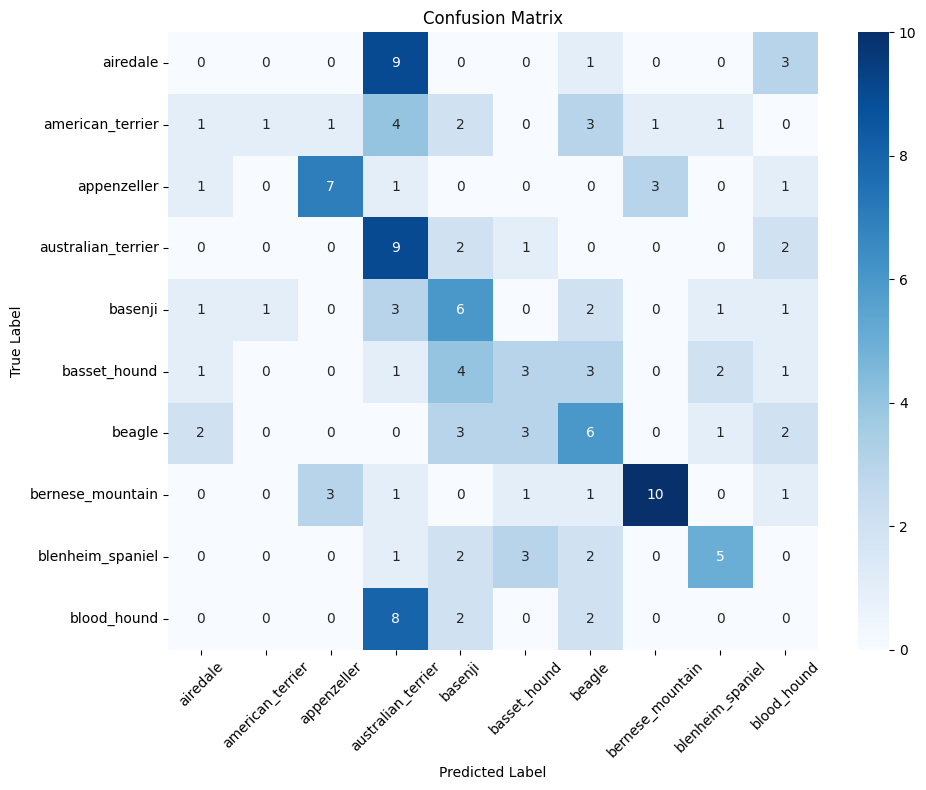


Epoch 26/30
Train Loss: 1.2523
Val Accuracy: 0.3287
Val Precision: 0.3452
Val Recall: 0.3179
Val F1: 0.3030


Epoch 27/30: 100%|██████████| 36/36 [01:19<00:00,  2.21s/it]


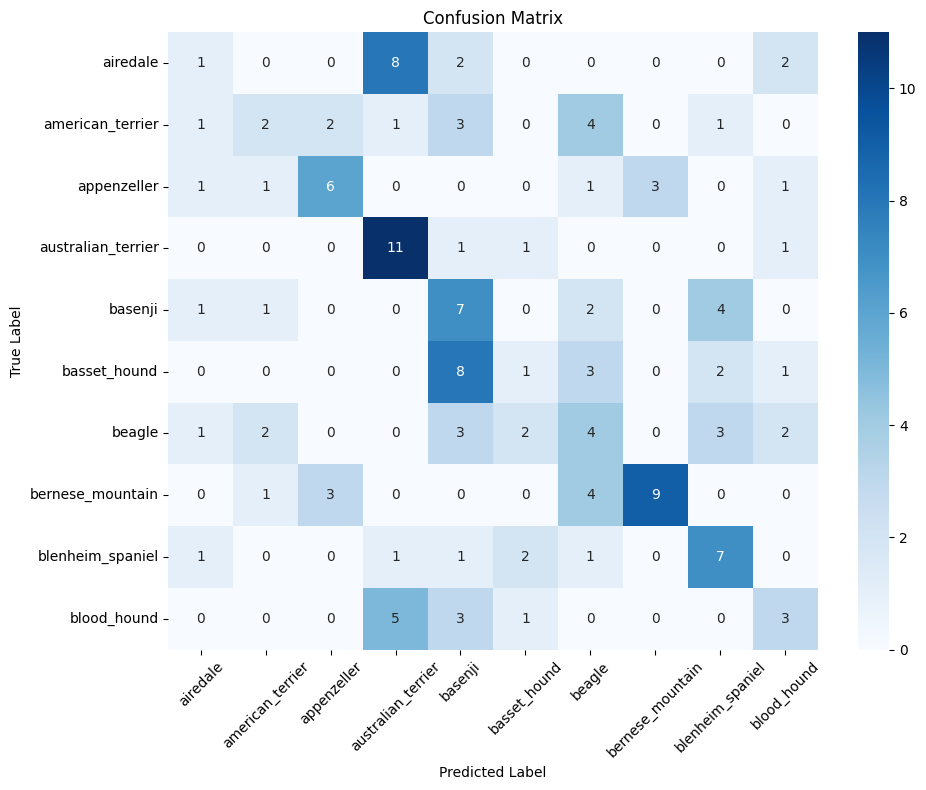


Epoch 27/30
Train Loss: 1.1880
Val Accuracy: 0.3566
Val Precision: 0.3486
Val Recall: 0.3554
Val F1: 0.3345


Epoch 28/30: 100%|██████████| 36/36 [01:19<00:00,  2.20s/it]


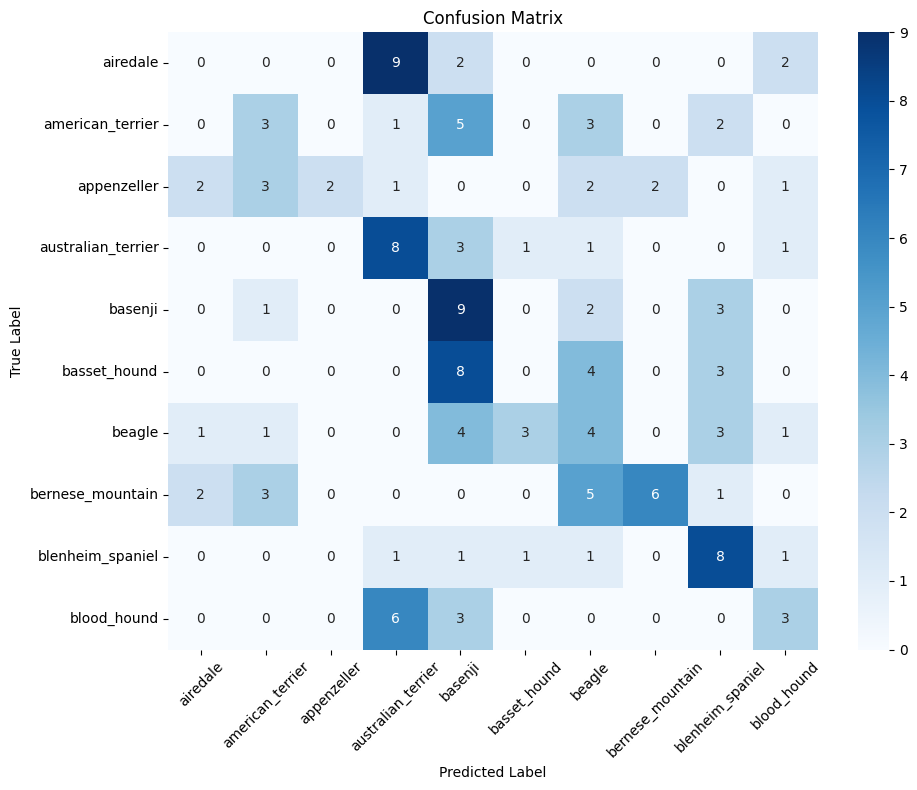


Epoch 28/30
Train Loss: 1.1437
Val Accuracy: 0.3007
Val Precision: 0.3503
Val Recall: 0.2993
Val F1: 0.2722
Epoch 00028: reducing learning rate of group 0 to 2.0000e-05.


Epoch 29/30: 100%|██████████| 36/36 [01:20<00:00,  2.23s/it]


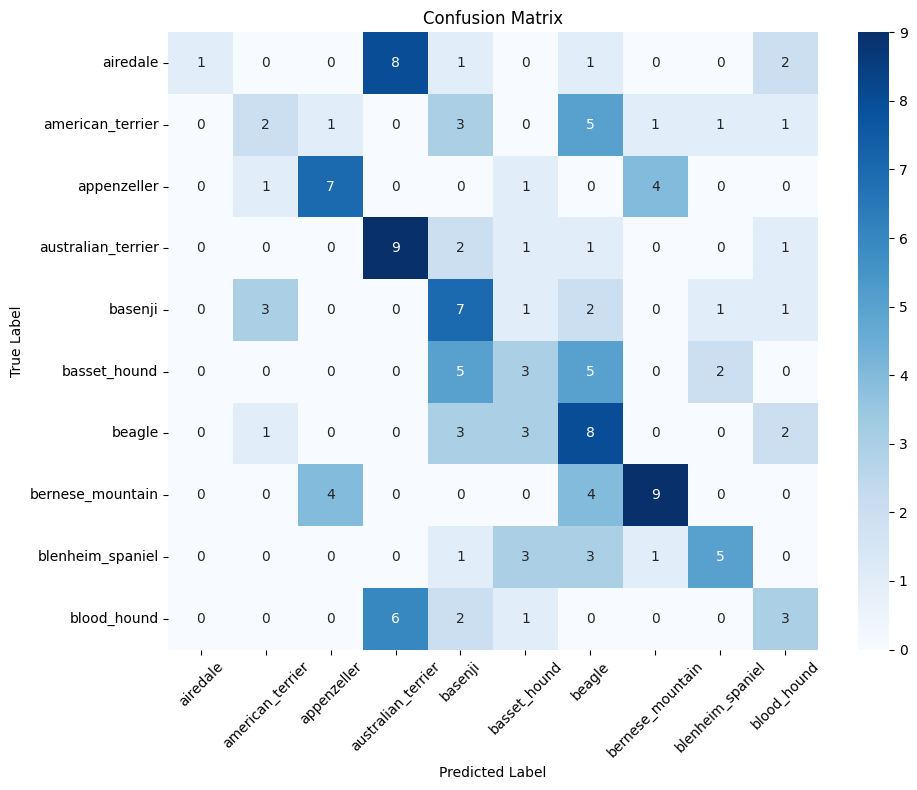


Epoch 29/30
Train Loss: 1.0632
Val Accuracy: 0.3776
Val Precision: 0.4514
Val Recall: 0.3702
Val F1: 0.3591


Epoch 30/30: 100%|██████████| 36/36 [01:25<00:00,  2.38s/it]


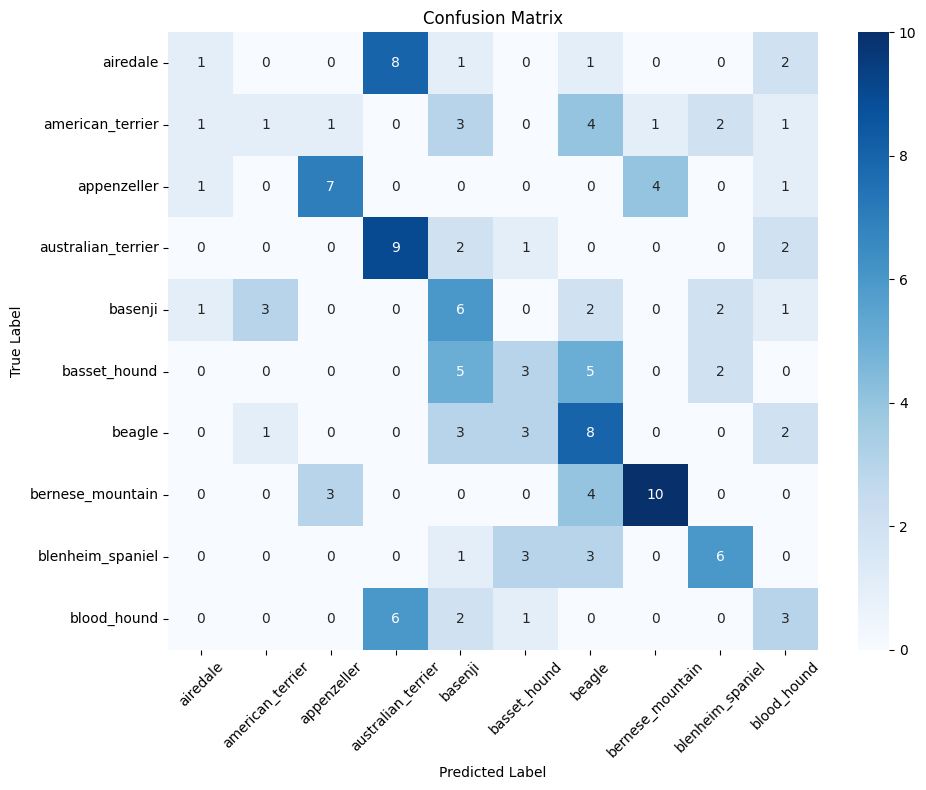


Epoch 30/30
Train Loss: 1.0359
Val Accuracy: 0.3776
Val Precision: 0.3724
Val Recall: 0.3700
Val F1: 0.3558

Model saved successfully!


In [78]:
model_2 = ImprovedResNet18(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_2.parameters(), 
                          lr=0.0002, 
                          momentum=0.9,
                          weight_decay=1e-4,
                          nesterov=True)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max', 
    factor=0.1, 
    patience=3,
    verbose=True)

best_val_f1_2 = 0.0

for epoch in range(epochs):
    # Обучение
    model_2.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader_2, desc=f'Epoch {epoch+1}/{epochs}'):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model_2(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Валидация
    val_accuracy_2, val_precision_2, val_recall_2, val_f1_2, val_cm_2 = evaluate(model_2, val_loader_2, class_names=full_dataset_2.classes)

    print(f"\nEpoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss/len(train_loader_2):.4f}")
    print(f"Val Accuracy: {val_accuracy_2:.4f}")
    print(f"Val Precision: {val_precision_2:.4f}")
    print(f"Val Recall: {val_recall_2:.4f}")
    print(f"Val F1: {val_f1_2:.4f}")
    
    scheduler.step(val_f1_2)  
    
    best_val_f1_2 = max(best_val_f1_2, val_f1_2)

torch.save(model_2.state_dict(), "impresnet18_best_model.pth")
print("\nModel saved successfully!")

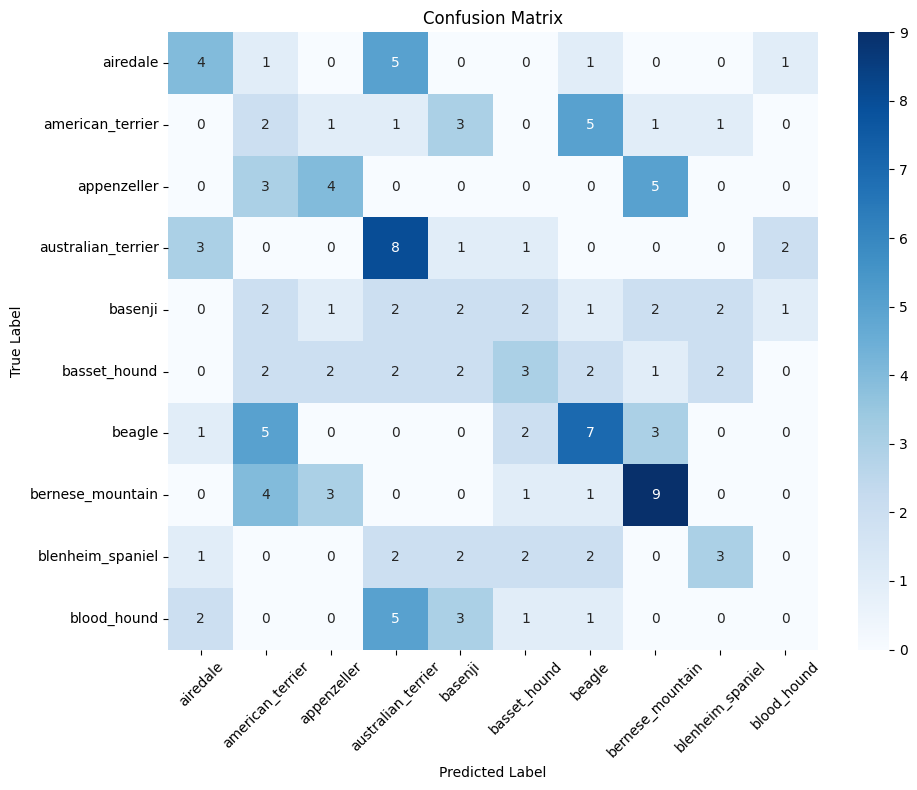


Test Results:
Accuracy: 0.2917
Precision: 0.2710
Recall: 0.2803
F1 Score: 0.2704


In [75]:
# Тестирования модели_2
test_accuracy_2, test_precision_2, test_recall_2, test_f1_2, test_cm_2 = evaluate(
    model_2, 
    test_loader_2,
    class_names=full_dataset_2.classes  
)

print("\nTest Results:")
print(f"Accuracy: {test_accuracy_2:.4f}")
print(f"Precision: {test_precision_2:.4f}")
print(f"Recall: {test_recall_2:.4f}")
print(f"F1 Score: {test_f1_2:.4f}")

#### ВЫВОД: анализируя результаты модели на тестовой выборке, можно сделать вывод, что существуют проблемы с обучением ( 0.29 Accuracy - крайне низкий)). Возможно это произошло из-за значительных измененией в архитектуре, что привело к быстрому сжатию features

### 3. Использование предобученной модели ResNet на датасете ImageNet
#### Модель - ResNet
#### Функция потерь - CrossEntropyLoss
#### Оптимизатор - Adam
#### Аугментации - RandomResizedCrop, RandomHorizontalFlip, ColorJitter, ToTensor, Normalize

In [94]:
# Проверка устройства
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_3 = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
num_classes = 10  # Замените на ваше количество классов
num_ftrs = model_3.fc.in_features
model_3.fc = nn.Linear(num_ftrs, num_classes)
model_3 = model_3.to(device)

criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.Adam(model_3.parameters(), lr=0.001)  

In [95]:
def calculate_metrics(outputs, labels):
    """Корректное вычисление метрик"""
    # Получаем предсказанные классы
    _, preds = torch.max(outputs, 1)
    
    # Преобразуем в numpy arrays
    preds = preds.detach().cpu().numpy().flatten()  # Используем flatten вместо ravel
    labels = labels.detach().cpu().numpy().flatten()
    
    # Вычисляем метрики
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average='weighted', zero_division=0)
    recall = recall_score(labels, preds, average='weighted', zero_division=0)
    f1 = f1_score(labels, preds, average='weighted', zero_division=0)
    
    return accuracy, precision, recall, f1, preds, labels

def evaluate_model(model, criterion, dataloader):
    """Оценка модели"""
    model.eval()
    running_loss = 0.0
    running_accuracy = 0.0
    running_precision = 0.0
    running_recall = 0.0
    running_f1 = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Evaluating'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            acc, prec, rec, f1, preds, true_labels = calculate_metrics(outputs, labels)
            
            running_accuracy += acc * inputs.size(0)
            running_precision += prec * inputs.size(0)
            running_recall += rec * inputs.size(0)
            running_f1 += f1 * inputs.size(0)
            all_preds.extend(preds)
            all_labels.extend(true_labels)
    
    total = len(dataloader.dataset)
    avg_loss = running_loss / total
    avg_acc = running_accuracy / total
    avg_prec = running_precision / total
    avg_rec = running_recall / total
    avg_f1 = running_f1 / total
    
    return avg_loss, avg_acc, avg_prec, avg_rec, avg_f1, all_preds, all_labels

In [97]:
def train_model(model, criterion, optimizer, epochs):
    best_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_f1': []}
    
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        print('-' * 10)
        
        # Фаза обучения
        model.train()
        running_loss = 0.0
        running_accuracy = 0.0
        
        for inputs, labels in tqdm(train_loader, desc='Training'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            acc, _, _, _, _, _ = calculate_metrics(outputs, labels)
            running_accuracy += acc * inputs.size(0)
        
        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_accuracy / len(train_dataset)
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)
        
        # Фаза валидации
        val_loss, val_acc, val_prec, val_rec, val_f1, _, _ = evaluate_model(model, criterion, val_loader)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['val_f1'].append(val_f1)
        
        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f} Acc: {val_acc:.4f} F1: {val_f1:.4f}')
        
        # Сохраняем лучшую модель
        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), 'best_model_resnet18_pred.pth')
    
    return history, model

history, trained_model = train_model(model_3, criterion_3, optimizer_3, epochs)

Epoch 1/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.25it/s]


Train Loss: 0.9227 Acc: 0.6856
Val Loss: 1.1861 Acc: 0.6294 F1: 0.6170
Epoch 2/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Train Loss: 0.4325 Acc: 0.8576
Val Loss: 0.6726 Acc: 0.7692 F1: 0.7727
Epoch 3/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


Train Loss: 0.2186 Acc: 0.9345
Val Loss: 0.7845 Acc: 0.7203 F1: 0.7110
Epoch 4/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Train Loss: 0.1793 Acc: 0.9336
Val Loss: 0.8271 Acc: 0.7692 F1: 0.7602
Epoch 5/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Train Loss: 0.1960 Acc: 0.9362
Val Loss: 1.6096 Acc: 0.5804 F1: 0.5520
Epoch 6/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.30it/s]


Train Loss: 0.1927 Acc: 0.9362
Val Loss: 0.9408 Acc: 0.7063 F1: 0.7051
Epoch 7/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Train Loss: 0.1701 Acc: 0.9450
Val Loss: 1.7178 Acc: 0.6224 F1: 0.5820
Epoch 8/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Train Loss: 0.1493 Acc: 0.9555
Val Loss: 1.0076 Acc: 0.7133 F1: 0.7188
Epoch 9/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Train Loss: 0.1370 Acc: 0.9520
Val Loss: 1.1031 Acc: 0.6643 F1: 0.6622
Epoch 10/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


Train Loss: 0.1198 Acc: 0.9633
Val Loss: 0.7918 Acc: 0.7622 F1: 0.7541
Epoch 11/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Train Loss: 0.0737 Acc: 0.9808
Val Loss: 0.6240 Acc: 0.7692 F1: 0.7744
Epoch 12/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Train Loss: 0.0346 Acc: 0.9886
Val Loss: 0.5911 Acc: 0.7902 F1: 0.7794
Epoch 13/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.03it/s]


Train Loss: 0.0399 Acc: 0.9895
Val Loss: 0.8317 Acc: 0.7552 F1: 0.7529
Epoch 14/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.01it/s]


Train Loss: 0.0207 Acc: 0.9956
Val Loss: 0.8224 Acc: 0.7972 F1: 0.7944
Epoch 15/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.04it/s]


Train Loss: 0.0317 Acc: 0.9895
Val Loss: 0.4975 Acc: 0.8531 F1: 0.8532
Epoch 16/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


Train Loss: 0.0459 Acc: 0.9808
Val Loss: 0.8760 Acc: 0.7133 F1: 0.7248
Epoch 17/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Train Loss: 0.1274 Acc: 0.9563
Val Loss: 0.8824 Acc: 0.7622 F1: 0.7429
Epoch 18/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train Loss: 0.1130 Acc: 0.9677
Val Loss: 0.7252 Acc: 0.8042 F1: 0.8128
Epoch 19/30
----------


Evaluating: 100%|██████████| 5/5 [00:04<00:00,  1.25it/s]


Train Loss: 0.0541 Acc: 0.9790
Val Loss: 1.1261 Acc: 0.6713 F1: 0.6532
Epoch 20/30
----------


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


Train Loss: 0.0578 Acc: 0.9834
Val Loss: 0.5891 Acc: 0.8531 F1: 0.8569
Epoch 21/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.28it/s]


Train Loss: 0.0730 Acc: 0.9764
Val Loss: 1.0206 Acc: 0.7413 F1: 0.7423
Epoch 22/30
----------


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Train Loss: 0.0380 Acc: 0.9878
Val Loss: 1.0040 Acc: 0.7343 F1: 0.7318
Epoch 23/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Train Loss: 0.0628 Acc: 0.9755
Val Loss: 1.1276 Acc: 0.7063 F1: 0.6950
Epoch 24/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.64it/s]


Train Loss: 0.0488 Acc: 0.9860
Val Loss: 0.5882 Acc: 0.7902 F1: 0.7945
Epoch 25/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.66it/s]


Train Loss: 0.0271 Acc: 0.9913
Val Loss: 0.6994 Acc: 0.7972 F1: 0.7889
Epoch 26/30
----------


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.69it/s]


Train Loss: 0.0454 Acc: 0.9869
Val Loss: 1.0482 Acc: 0.7483 F1: 0.7253
Epoch 27/30
----------


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.68it/s]


Train Loss: 0.0245 Acc: 0.9921
Val Loss: 0.7344 Acc: 0.7622 F1: 0.7687
Epoch 28/30
----------


Evaluating: 100%|██████████| 5/5 [00:03<00:00,  1.67it/s]


Train Loss: 0.0276 Acc: 0.9869
Val Loss: 0.6765 Acc: 0.8182 F1: 0.8181
Epoch 29/30
----------


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]


Train Loss: 0.0258 Acc: 0.9895
Val Loss: 0.6026 Acc: 0.8392 F1: 0.8233
Epoch 30/30
----------


Evaluating: 100%|██████████| 5/5 [00:02<00:00,  1.67it/s]

Train Loss: 0.0143 Acc: 0.9939
Val Loss: 0.4793 Acc: 0.8951 F1: 0.8982


In [101]:
# Тестирование модели
def test_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Вычисление метрик
    accuracy = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='weighted', zero_division=0
    )
    
    # Вывод метрик
    print('\nTest Metrics:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # # Classification Report
    # print('\nClassification Report:')
    # print(classification_report(all_labels, all_preds, target_names=class_names, zero_division=0))
    
    # # Confusion Matrix
    # cm = confusion_matrix(all_labels, all_preds)
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
    #             xticklabels=class_names, yticklabels=class_names)
    # plt.title('Confusion Matrix')
    # plt.xlabel('Predicted')
    # plt.ylabel('True')
    # plt.show()
    
    return accuracy, precision, recall, f1

# Загрузка лучшей модели
best_model = models.resnet18(weights=None)
num_ftrs = best_model.fc.in_features
best_model.fc = nn.Linear(num_ftrs, num_classes)
best_model.load_state_dict(torch.load('best_model_resnet18_pred.pth'))
best_model = best_model.to(device)

test_accuracy, test_precision, test_recall, test_f1 = test_model(best_model, test_loader)

Testing: 100%|██████████| 5/5 [00:02<00:00,  1.91it/s]


Test Metrics:
Accuracy: 0.7917
Precision: 0.8043
Recall: 0.7917
F1 Score: 0.7922


#### ВЫВОД: Предобученные на ImageNet features хорошо перенеслись на мою задачу, а дообучение помогло адаптировать можель под классификацию пород. В результате 80% пород были определены верно

### ОБЩИЙ ВЫВОД: После всех эксперементов наилуший результат показала последняя предобученная модель, поэтому было принято решение обучить данную модель на полном датасете и сравнить решение с моделью логистической регрессии